In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import umap
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import rbf_kernel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score
import optuna
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import hdbscan 
from sklearn.metrics.pairwise import polynomial_kernel
from scipy.stats import mode
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from joblib import Parallel, delayed
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
import json
import joblib
from Bio import SeqIO
from sklearn.feature_selection import SelectKBest, f_classif
import json
import shap
import pickle
from bio_embeddings.embed import ProtTransBertBFDEmbedder
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# CUDA & Torch Info
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU detected'}")

2025-08-04 15:39:43.516398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-04 15:39:43.516471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-04 15:39:43.516518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-04 15:39:43.523261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-04 15:39:46.260793: W tensorflow/compiler/

PyTorch Version: 1.9.1+cu102
CUDA Version: 10.2
CUDA Available: True
GPU Name: NVIDIA A100-SXM4-40GB


In [2]:
embedder = ProtTransBertBFDEmbedder()
device = torch.device("cuda:0")  # Use GPU 0
#mbedder = embedder.to(device)

In [3]:
data = '../alphafold/AF2_disorder_all_features.csv'

data_df = pd.read_csv(data)
data_df['seq_mut'] = data_df['mut_seq']
data_df = data_df.loc[:, ~data_df.columns.str.startswith(('ref_', 'mut_'))]

,AlphaMissense_rankscore,ESM1b_rankscore,EVE_rankscore,mutation,Class,WT,abs_delta_asphericity,abs_delta_radius_of_gyration,abs_delta_end_to_end_distance,abs_delta_scaling_exponent,...,abs_delta_Asx,abs_delta_Glx,abs_delta_Xle,abs_delta_Pos_charge,abs_delta_Neg_charge,abs_delta_Aromatic,abs_delta_Alipatic,abs_delta_lcs_score,abs_delta_lcs_fraction,seq_mut
0,0.32275,0.08491,0.39711,A1011E,Neutral,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...,0.000456,0.017019,0.131171,0.000666,...,0,1,0,0,1,0,0,0.0,0.000000,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...
1,0.11510,0.12914,0.28879,A1129V,Neutral,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...,0.000012,0.019358,0.040724,0.000087,...,0,0,0,0,0,0,1,0.0,0.000000,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...
2,0.64316,0.20417,0.58234,C1104Y,Neutral,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...,0.002133,0.300385,0.682422,0.002192,...,0,0,0,0,0,1,0,0.0,0.000000,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...
3,0.34536,0.18031,0.26008,D1146H,Neutral,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...,0.000345,0.080911,0.397961,0.000370,...,1,0,0,1,1,1,0,0.0,0.000000,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...
4,0.73025,0.12505,0.79584,E1101D,Neutral,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...,0.000078,0.013206,0.017232,0.000021,...,1,1,0,0,0,0,0,0.0,0.000000,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,0.11797,0.29257,0.00000,V4I,Neutral,MKRVLVLLLAVAFGHALERGRDY,0.000624,0.022430,0.150302,0.001627,...,0,0,1,0,0,0,0,0.0,0.000000,MKRILVLLLAVAFGHALERGRDY
2100,0.00125,0.01750,0.00000,V552A,Neutral,FQDASDDGSGSGSGDGCLDDLCSRKVSRKSSSSRTPLTHALPGLSE...,0.001823,0.031386,0.144389,0.000068,...,0,0,0,0,0,0,1,5.0,0.080645,FQDASDDGSGSGSGDGCLDDLCSRKVSRKSSSSRTPLTHALPGLSE...
2101,0.94534,0.81463,0.90820,Y196H,Deleterious,IIVPIFLLLDKDDSKAGMEEDHTYEGLDIDQTATYEDIVTLRTGEV...,0.000338,0.012051,0.088943,0.001853,...,0,0,0,1,0,0,0,0.0,0.000000,IIVPIFLLLDKDDSKAGMEEDHTHEGLDIDQTATYEDIVTLRTGEV...
2102,0.64435,0.88531,0.00000,Y311S,Neutral,AHSRWIADPSPQNSTADTSKVSLGLDENVSKRIEPSVSLWQFYL,0.005744,0.106898,1.553197,0.019815,...,0,0,0,0,0,1,0,0.0,0.000000,AHSRWIADPSPQNSTADTSKVSLGLDENVSKRIEPSVSLWQFSL


In [4]:
def get_emb(a):
    per_residue_embedding = embedder.embed(a)
    per_residue_embedding = embedder.reduce_per_protein(per_residue_embedding)
    #print(per_residue_embedding)
    return per_residue_embedding


In [5]:

data_df['wt_emb'] = data_df['WT'].apply(lambda x:get_emb(x))

data_df['mut_emb'] = data_df['seq_mut'].apply(lambda x:get_emb(x))
data_df.to_json('AF2_data_with_emb.json', orient='records', lines=True)
delta_emb_df = data_df.copy()
delta_emb_df['delta_emb_L1'] = delta_emb_df.apply(lambda row: np.abs(row['wt_emb'] - row['mut_emb']), axis=1)

# Compute L2 distance: Squared difference
delta_emb_df['delta_emb_L2'] = delta_emb_df.apply(lambda row: np.square(row['wt_emb'] - row['mut_emb']), axis=1)

# Compute average of embeddings
delta_emb_df['delta_emb_average'] = delta_emb_df.apply(lambda row: (row['wt_emb'] + row['mut_emb']) / 2, axis=1)

# Compute Hadamard product: Element-wise multiplication
delta_emb_df['delta_emb_hadamard'] = delta_emb_df.apply(lambda row: row['wt_emb'] * row['mut_emb'], axis=1)
delta_emb_df.to_json('AF2_data_with_emb_l1_l2_average.json', orient='records', lines=True)


In [6]:
delta_emb_df = pd.read_json('AF2_data_with_emb_l1_l2_average.json', lines=True)

features_all = ['abs_delta_asphericity', 'abs_delta_radius_of_gyration',
       'abs_delta_end_to_end_distance', 'abs_delta_scaling_exponent',
       'abs_delta_prefactor', 'GERP++_RS_rankscore',
       'GERP_91_mammals_rankscore', 'phyloP100way_vertebrate_rankscore',
       'phyloP470way_mammalian_rankscore', 'phyloP17way_primate_rankscore',
       'phastCons100way_vertebrate_rankscore',
       'phastCons470way_mammalian_rankscore',
       'phastCons17way_primate_rankscore', 'SiPhy_29way_logOdds_rankscore','abs_delta_hpi_1.5_frac',
       'abs_delta_hpi_1.5', 'abs_delta_hpi_2.0_frac', 'abs_delta_hpi_2.0',
       'abs_delta_hpi_2.5_frac', 'abs_delta_hpi_2.5', 'abs_delta_length',
       'abs_delta_fraction_A', 'abs_delta_fraction_C', 'abs_delta_fraction_D',
       'abs_delta_fraction_E', 'abs_delta_fraction_F', 'abs_delta_fraction_G',
       'abs_delta_fraction_H', 'abs_delta_fraction_I', 'abs_delta_fraction_K',
       'abs_delta_fraction_L', 'abs_delta_fraction_M', 'abs_delta_fraction_N',
       'abs_delta_fraction_P', 'abs_delta_fraction_Q', 'abs_delta_fraction_R',
       'abs_delta_fraction_S', 'abs_delta_fraction_T', 'abs_delta_fraction_V',
       'abs_delta_fraction_W', 'abs_delta_fraction_Y', 'abs_delta_IEP',
       'abs_delta_molecular_weight', 'abs_delta_gravy', 'abs_delta_Asx',
       'abs_delta_Glx', 'abs_delta_Xle', 'abs_delta_Pos_charge',
       'abs_delta_Neg_charge', 'abs_delta_Aromatic', 'abs_delta_Alipatic',
       'abs_delta_lcs_score', 'abs_delta_lcs_fraction']


features_nocon = ['abs_delta_asphericity', 'abs_delta_radius_of_gyration',
       'abs_delta_end_to_end_distance', 'abs_delta_scaling_exponent',
       'abs_delta_prefactor','abs_delta_hpi_1.5_frac',
       'abs_delta_hpi_1.5', 'abs_delta_hpi_2.0_frac', 'abs_delta_hpi_2.0',
       'abs_delta_hpi_2.5_frac', 'abs_delta_hpi_2.5', 'abs_delta_length',
       'abs_delta_fraction_A', 'abs_delta_fraction_C', 'abs_delta_fraction_D',
       'abs_delta_fraction_E', 'abs_delta_fraction_F', 'abs_delta_fraction_G',
       'abs_delta_fraction_H', 'abs_delta_fraction_I', 'abs_delta_fraction_K',
       'abs_delta_fraction_L', 'abs_delta_fraction_M', 'abs_delta_fraction_N',
       'abs_delta_fraction_P', 'abs_delta_fraction_Q', 'abs_delta_fraction_R',
       'abs_delta_fraction_S', 'abs_delta_fraction_T', 'abs_delta_fraction_V',
       'abs_delta_fraction_W', 'abs_delta_fraction_Y', 'abs_delta_IEP',
       'abs_delta_molecular_weight', 'abs_delta_gravy', 'abs_delta_Asx',
       'abs_delta_Glx', 'abs_delta_Xle', 'abs_delta_Pos_charge',
       'abs_delta_Neg_charge', 'abs_delta_Aromatic', 'abs_delta_Alipatic',
       'abs_delta_lcs_score', 'abs_delta_lcs_fraction']

L1_features = features_nocon + ['delta_emb_L1']
L2_features = features_nocon + ['delta_emb_L2']
average_features = features_nocon + ['delta_emb_average']
hadamard_features = features_nocon + ['delta_emb_hadamard']

L1_features_eve = features_nocon + ['delta_emb_L1', 'EVE_rankscore']
L2_features_eve = features_nocon + ['delta_emb_L2', 'EVE_rankscore']
average_features_eve = features_nocon + ['delta_emb_average', 'EVE_rankscore']
hadamard_features_eve = features_nocon + ['delta_emb_hadamard', 'EVE_rankscore']

L1_features_am = features_nocon + ['delta_emb_L1', 'AlphaMissense_rankscore']
L2_features_am = features_nocon + ['delta_emb_L2', 'AlphaMissense_rankscore']
average_features_am = features_nocon + ['delta_emb_average', 'AlphaMissense_rankscore']
hadamard_features_am = features_nocon + ['delta_emb_hadamard', 'AlphaMissense_rankscore']


L1_features_esm1 = features_nocon + ['delta_emb_L1', 'ESM1b_rankscore']
L2_features_esm1 = features_nocon + ['delta_emb_L2', 'ESM1b_rankscore']
average_features_esm1 = features_nocon + ['delta_emb_average', 'ESM1b_rankscore']
hadamard_features_esm = features_nocon + ['delta_emb_hadamard', 'ESM1b_rankscore']


delta_emb_L1_df = delta_emb_df[L1_features]
delta_emb_L2_df = delta_emb_df[L2_features]
delta_emb_average_df = delta_emb_df[average_features]
delta_emb_hadamard_df = delta_emb_df[hadamard_features]

delta_eve_emb_L1_df = delta_emb_df[L1_features_eve]
delta_eve_emb_L2_df = delta_emb_df[L2_features_eve]
delta_eve_emb_average_df = delta_emb_df[average_features_eve]
delta_eve_emb_hadamard_df = delta_emb_df[hadamard_features_eve]


delta_emb_L1_esm_df = delta_emb_df[L1_features_esm1]
delta_emb_L2_esm_df = delta_emb_df[L2_features_esm1]
delta_emb_average_esm_df = delta_emb_df[average_features_esm1]
delta_emb_hadamard_esm_df = delta_emb_df[hadamard_features_esm]


delta_emb_L1_am_df = delta_emb_df[L1_features_am]
delta_emb_L2_am_df = delta_emb_df[L2_features_am]
delta_emb_average_am_df = delta_emb_df[average_features_am]
delta_emb_hadamard_am_df = delta_emb_df[hadamard_features_am]

def expand_array_column(df, array_column_name, class_column_name=None):
    if array_column_name not in df.columns:
        raise ValueError(f"Column '{array_column_name}' not found in the DataFrame.")
    
    # Expand the array column into separate columns
    array_columns = df[array_column_name].apply(pd.Series)
    array_columns.columns = [f'{array_column_name}_value_{i+1}' for i in range(array_columns.shape[1])]
    
    # Drop the original array column and concatenate the expanded columns
    expanded_df = pd.concat([df.drop(columns=[array_column_name]), array_columns], axis=1)
    
    # Retain the class column if specified
    if class_column_name and class_column_name in df.columns:
        expanded_df[class_column_name] = df[class_column_name]
    
    return expanded_df


delta_emb_L1_df = expand_array_column(delta_emb_L1_df, 'delta_emb_L1')
delta_emb_L2_df = expand_array_column(delta_emb_L2_df, 'delta_emb_L2')
delta_emb_average_df = expand_array_column(delta_emb_average_df, 'delta_emb_average')
delta_emb_hadamard_df = expand_array_column(delta_emb_hadamard_df, 'delta_emb_hadamard')


delta_eve_emb_L1_df = expand_array_column(delta_eve_emb_L1_df, 'delta_emb_L1')
delta_eve_emb_L2_df = expand_array_column(delta_eve_emb_L2_df, 'delta_emb_L2')
delta_eve_emb_average_df = expand_array_column(delta_eve_emb_average_df, 'delta_emb_average')
delta_eve_emb_hadamard_df = expand_array_column(delta_eve_emb_hadamard_df, 'delta_emb_hadamard')


delta_esm_emb_L1_df = expand_array_column(delta_emb_L1_esm_df, 'delta_emb_L1')
delta_esm_emb_L2_df = expand_array_column(delta_emb_L2_esm_df, 'delta_emb_L2')
delta_esm_emb_average_df = expand_array_column(delta_emb_average_esm_df, 'delta_emb_average')
delta_esm_emb_hadamard_df = expand_array_column(delta_emb_hadamard_esm_df, 'delta_emb_hadamard')

delta_am_emb_L1_df = expand_array_column(delta_emb_L1_am_df, 'delta_emb_L1')
delta_am_emb_L2_df = expand_array_column(delta_emb_L2_am_df, 'delta_emb_L2')
delta_am_emb_average_df = expand_array_column(delta_emb_average_am_df, 'delta_emb_average')
delta_am_emb_hadamard_df = expand_array_column(delta_emb_hadamard_am_df, 'delta_emb_hadamard')


,abs_delta_asphericity,abs_delta_radius_of_gyration,abs_delta_end_to_end_distance,abs_delta_scaling_exponent,abs_delta_prefactor,abs_delta_hpi_1.5_frac,abs_delta_hpi_1.5,abs_delta_hpi_2.0_frac,abs_delta_hpi_2.0,abs_delta_hpi_2.5_frac,...,delta_emb_L1_value_1015,delta_emb_L1_value_1016,delta_emb_L1_value_1017,delta_emb_L1_value_1018,delta_emb_L1_value_1019,delta_emb_L1_value_1020,delta_emb_L1_value_1021,delta_emb_L1_value_1022,delta_emb_L1_value_1023,delta_emb_L1_value_1024
0,0.000456,0.017019,0.131171,0.000666,0.004899,0.014925,3,0.024876,5,0.0,...,0.001849,0.002792,0.002833,0.000031,0.002036,0.001703,0.001875,0.001195,0.001215,0.002339
1,0.000012,0.019358,0.040724,0.000087,0.004465,0.000000,0,0.000000,0,0.0,...,0.000634,0.003839,0.002122,0.003758,0.005293,0.001055,0.001115,0.003499,0.001435,0.001290
2,0.002133,0.300385,0.682422,0.002192,0.026192,0.019900,4,0.000000,0,0.0,...,0.004072,0.001101,0.001668,0.002534,0.001335,0.000840,0.002256,0.003375,0.002559,0.002744
3,0.000345,0.080911,0.397961,0.000370,0.012559,0.000000,0,0.000000,0,0.0,...,0.000350,0.001052,0.002155,0.002724,0.000389,0.000331,0.000314,0.001588,0.001473,0.001798
4,0.000078,0.013206,0.017232,0.000021,0.002676,0.000000,0,0.000000,0,0.0,...,0.000756,0.001026,0.000809,0.000909,0.001415,0.000044,0.000653,0.000316,0.000954,0.000114


In [7]:
def feature_selection_on_embeddings(embeddings, y, target_dim=20):
    selector = SelectKBest(score_func=f_classif, k=target_dim)
    embeddings_selected = selector.fit_transform(embeddings, y)
    
    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)
    selected_scores = selector.scores_[selected_indices]
    
    print(f"Selected embedding dimensions: {selected_indices[:10]}...")
    print(f"Top 5 F-scores: {sorted(selected_scores, reverse=True)[:5]}")
    
    return embeddings_selected, selector, f"FS_{target_dim}d", selected_indices

def apply_embedding_selection_to_dataframes(delta_emb_df, target_dim=20):
    """
    Apply embedding feature selection to all ESM dataframes
    """
    le = LabelEncoder()
    y_encoded = le.fit_transform(delta_emb_df['Class'])
    print(f"Class encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    
    # Dictionary to store results
    selection_results = {}
    processed_dataframes = {}
    
    # Define the dataframes to process
    dataframes_to_process = {
        'delta_esm_emb_L1_df': delta_esm_emb_L1_df,
        'delta_esm_emb_L2_df': delta_esm_emb_L2_df,
        'delta_esm_emb_average_df': delta_esm_emb_average_df,
        'delta_esm_emb_hadamard_df': delta_esm_emb_hadamard_df
    }
    
    for df_name, df in dataframes_to_process.items():
        print(f"\n{'-'*50}")
        print(f"Processing: {df_name}")
        print(f"{'-'*50}")
        
        # Identify embedding columns (those starting with delta_emb_ and containing _value_)
        embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
        
        # Identify non-embedding columns
        non_embedding_cols = [col for col in df.columns if col not in embedding_cols]
        
        print(f"Found {len(embedding_cols)} embedding columns")
        print(f"Found {len(non_embedding_cols)} non-embedding columns")
        print(f"Sample embedding columns: {embedding_cols[:5]}")
        print(f"Non-embedding columns: {non_embedding_cols}")
        
        if len(embedding_cols) == 0:
            processed_dataframes[df_name] = df.copy()
            continue
        
        # Extract embedding features
        X_embeddings = df[embedding_cols]
        
        # Apply feature selection
        try:
            embeddings_selected, selector, reduction_method, selected_indices = feature_selection_on_embeddings(
                X_embeddings, y_encoded, target_dim=target_dim
            )
            
            # Create new column names for selected embeddings
            selected_embedding_cols = [embedding_cols[i] for i in selected_indices]
            
            # Create DataFrame with selected embeddings
            selected_embeddings_df = pd.DataFrame(
                embeddings_selected,
                columns=selected_embedding_cols,
                index=df.index
            )
            
            # Combine selected embeddings with non-embedding features
            processed_df = pd.concat([
                df[non_embedding_cols],  # Keep all non-embedding features
                selected_embeddings_df   # Add selected embedding features
            ], axis=1)
            
            # Store results
            processed_dataframes[df_name] = processed_df
            selection_results[df_name] = {
                'original_embedding_dims': len(embedding_cols),
                'selected_embedding_dims': len(selected_embedding_cols),
                'reduction_percentage': (1 - len(selected_embedding_cols)/len(embedding_cols)) * 100,
                'selector': selector,
                'selected_indices': selected_indices,
                'selected_columns': selected_embedding_cols,
                'reduction_method': reduction_method
            }
            
            print(f"✅ Successfully reduced from {len(embedding_cols)} to {len(selected_embedding_cols)} embedding dimensions")
            print(f"   Reduction: {selection_results[df_name]['reduction_percentage']:.1f}%")
            print(f"   Final dataframe shape: {processed_df.shape}")
            
        except Exception as e:
            processed_dataframes[df_name] = df.copy()
            continue
    
    return processed_dataframes, selection_results

def verify_feature_selection_results(processed_dataframes, selection_results):
    
    for df_name, df in processed_dataframes.items():
        print(f"\n{df_name}:")
        
        # Count different types of features
        embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
        abs_delta_cols = [col for col in df.columns if col.startswith('abs_delta_')]
        rankscore_cols = [col for col in df.columns if 'rankscore' in col]
        other_cols = [col for col in df.columns if col not in embedding_cols + abs_delta_cols + rankscore_cols]
        
        print(f"  Total columns: {len(df.columns)}")
        print(f"  Embedding features: {len(embedding_cols)}")
        print(f"  abs_delta features: {len(abs_delta_cols)}")
        print(f"  Rankscore features: {len(rankscore_cols)}")
        print(f"  Other features: {len(other_cols)}")
        
        if df_name in selection_results:
            result = selection_results[df_name]
            print(f"  Embedding reduction: {result['original_embedding_dims']} → {result['selected_embedding_dims']} ({result['reduction_percentage']:.1f}%)")
        
        # Show sample embedding columns
        if embedding_cols:
            print(f"  Sample embedding columns: {embedding_cols[:3]}")

def create_embedding_importance_analysis(selection_results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (df_name, results) in enumerate(selection_results.items()):
        if i >= 4:  # Only plot first 4
            break
            
        ax = axes[i]
        
        # Get feature scores and selected indices
        selector = results['selector']
        selected_indices = results['selected_indices']
        all_scores = selector.scores_
        selected_scores = all_scores[selected_indices]
        
        # Create histogram of all scores vs selected scores
        ax.hist(all_scores, bins=50, alpha=0.7, label='All embedding dims', color='lightblue')
        ax.hist(selected_scores, bins=20, alpha=0.8, label='Selected dims', color='orange')
        
        ax.set_xlabel('F-statistic Score')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{df_name}\nSelected: {len(selected_indices)}/{len(all_scores)} dims')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        ax.text(0.05, 0.95, f'Mean selected: {np.mean(selected_scores):.2f}\nMean all: {np.mean(all_scores):.2f}', 
                transform=ax.transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('embedding_feature_selection_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    for df_name, results in selection_results.items():
        selector = results['selector']
        selected_indices = results['selected_indices']
        all_scores = selector.scores_
        selected_scores = all_scores[selected_indices]
        
        print(f"\n{df_name}:")
        print(f"  Selected indices: {selected_indices[:10]}...")
        print(f"  Score range (all): {np.min(all_scores):.2f} - {np.max(all_scores):.2f}")
        print(f"  Score range (selected): {np.min(selected_scores):.2f} - {np.max(selected_scores):.2f}")
        print(f"  Mean score improvement: {np.mean(selected_scores)/np.mean(all_scores):.2f}x")

def apply_selection_to_single_dataframe(df, df_name, y_encoded, target_dim=20):
    embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
    non_embedding_cols = [col for col in df.columns if col not in embedding_cols]
    
    if len(embedding_cols) == 0:
        print("No embedding columns found!")
        return df
    
    print(f"Found {len(embedding_cols)} embedding columns")
    
    # Apply feature selection
    X_embeddings = df[embedding_cols]
    embeddings_selected, selector, _, selected_indices = feature_selection_on_embeddings(
        X_embeddings, y_encoded, target_dim=target_dim
    )
    
    # Create selected embedding dataframe
    selected_cols = [embedding_cols[i] for i in selected_indices]
    selected_embeddings_df = pd.DataFrame(
        embeddings_selected, 
        columns=selected_cols, 
        index=df.index
    )
    
    # Combine with non-embedding features
    result_df = pd.concat([df[non_embedding_cols], selected_embeddings_df], axis=1)
    
    print(f"Reduced from {len(embedding_cols)} to {len(selected_cols)} embedding dimensions")
    return result_df

In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(delta_emb_df['Class'])

delta_emb_L1_df_selected = apply_selection_to_single_dataframe(
    delta_emb_L1_df, 'delta_emb_L1_df', y_encoded, target_dim=20
)

delta_emb_L2_df_selected = apply_selection_to_single_dataframe(
    delta_emb_L2_df, 'delta_emb_L2_df', y_encoded, target_dim=20
)

delta_emb_average_df_selected = apply_selection_to_single_dataframe(
    delta_emb_average_df, 'delta_emb_average_df', y_encoded, target_dim=20
)

delta_emb_hadamard_df_selected = apply_selection_to_single_dataframe(
    delta_emb_hadamard_df, 'delta_emb_hadamard_df', y_encoded, target_dim=20
)


delta_esm_emb_L1_df_selected = apply_selection_to_single_dataframe(
    delta_esm_emb_L1_df, 'delta_esm_emb_L1_df', y_encoded, target_dim=20
)

delta_esm_emb_L2_df_selected = apply_selection_to_single_dataframe(
    delta_esm_emb_L2_df, 'delta_esm_emb_L2_df', y_encoded, target_dim=20
)

delta_esm_emb_average_df_selected = apply_selection_to_single_dataframe(
    delta_esm_emb_average_df, 'delta_esm_emb_average_df', y_encoded, target_dim=20
)

delta_esm_emb_hadamard_df_selected = apply_selection_to_single_dataframe(
    delta_esm_emb_hadamard_df, 'delta_esm_emb_hadamard_df', y_encoded, target_dim=20
)


delta_eve_emb_L1_df_selected = apply_selection_to_single_dataframe(
    delta_eve_emb_L1_df, 'delta_eve_emb_L1_df', y_encoded, target_dim=20
)

delta_eve_emb_L2_df_selected = apply_selection_to_single_dataframe(
    delta_eve_emb_L2_df, 'delta_eve_emb_L2_df', y_encoded, target_dim=20
)

delta_eve_emb_average_df_selected = apply_selection_to_single_dataframe(
    delta_eve_emb_average_df, 'delta_eve_emb_average_df', y_encoded, target_dim=20
)

delta_eve_emb_hadamard_df_selected = apply_selection_to_single_dataframe(
    delta_eve_emb_hadamard_df, 'delta_eve_emb_hadamard_df', y_encoded, target_dim=20
)



# FIXED: Use correct variable names
delta_am_emb_L1_df_selected = apply_selection_to_single_dataframe(
    delta_am_emb_L1_df, 'delta_am_emb_L1_df', y_encoded, target_dim=20
)

delta_am_emb_L2_df_selected = apply_selection_to_single_dataframe(
    delta_am_emb_L2_df, 'delta_am_emb_L2_df', y_encoded, target_dim=20
)

delta_am_emb_average_df_selected = apply_selection_to_single_dataframe(
    delta_am_emb_average_df, 'delta_am_emb_average_df', y_encoded, target_dim=20
)

delta_am_emb_hadamard_df_selected = apply_selection_to_single_dataframe(
    delta_am_emb_hadamard_df, 'delta_am_emb_hadamard_df', y_encoded, target_dim=20
)



# Create summary of all processed dataframes
processed_dataframes = {
    # Vanilla embeddings
    'delta_emb_L1_df_selected': delta_emb_L1_df_selected,
    'delta_emb_L2_df_selected': delta_emb_L2_df_selected, 
    'delta_emb_average_df_selected': delta_emb_average_df_selected,
    'delta_emb_hadamard_df_selected': delta_emb_hadamard_df_selected,
    
    # ESM enhanced
    'delta_esm_emb_L1_df_selected': delta_esm_emb_L1_df_selected,
    'delta_esm_emb_L2_df_selected': delta_esm_emb_L2_df_selected,
    'delta_esm_emb_average_df_selected': delta_esm_emb_average_df_selected,
    'delta_esm_emb_hadamard_df_selected': delta_esm_emb_hadamard_df_selected,
    
    # EVE enhanced  
    'delta_eve_emb_L1_df_selected': delta_eve_emb_L1_df_selected,
    'delta_eve_emb_L2_df_selected': delta_eve_emb_L2_df_selected,
    'delta_eve_emb_average_df_selected': delta_eve_emb_average_df_selected,
    'delta_eve_emb_hadamard_df_selected': delta_eve_emb_hadamard_df_selected,
    
    # AlphaMissense enhanced
    'delta_am_emb_L1_df_selected': delta_am_emb_L1_df_selected,
    'delta_am_emb_L2_df_selected': delta_am_emb_L2_df_selected,
    'delta_am_emb_average_df_selected': delta_am_emb_average_df_selected,
    'delta_am_emb_hadamard_df_selected': delta_am_emb_hadamard_df_selected,
}

# Print summary
print(f"\nProcessed {len(processed_dataframes)} dataframes:")
for name, df in processed_dataframes.items():
    embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
    other_cols = [col for col in df.columns if col not in embedding_cols]
    rankscore_cols = [col for col in df.columns if 'rankscore' in col]
    
    print(f"  {name:35}: {df.shape} | Embeddings: {len(embedding_cols):2d} | Other: {len(other_cols):2d} | Rankscores: {len(rankscore_cols)}")


save_processed = False  # Set to True if you want to save
if save_processed:
    print(f"\nSaving processed dataframes...")
    for name, df in processed_dataframes.items():
        filename = f"{name}.csv"
        df.to_csv(filename, index=False)
        print(f"  Saved: {filename}")


Class encoding: {'Deleterious': 0, 'Neutral': 1}
Target variable shape: (2104,)

1. PROCESSING VANILLA EMBEDDING DATAFRAMES

Processing delta_emb_L1_df...
Found 1024 embedding columns

=== Method 4: Feature Selection on Embeddings ===
Original dimensions: 1024
Target dimensions: 20
Selected embedding dimensions: [ 27  94  96 171 178 240 261 349 419 424]...
Top 5 F-scores: [105.15047253434251, 100.28505932424797, 90.34108209040438, 90.09580456815827, 87.54415341400272]
Reduced from 1024 to 20 embedding dimensions

Processing delta_emb_L2_df...
Found 1024 embedding columns

=== Method 4: Feature Selection on Embeddings ===
Original dimensions: 1024
Target dimensions: 20
Selected embedding dimensions: [ 18  94 102 171 230 240 244 349 353 424]...
Top 5 F-scores: [41.10921071769078, 35.030455732399574, 33.106966955790945, 32.771855066840835, 32.5879119801921]
Reduced from 1024 to 20 embedding dimensions

Processing delta_emb_average_df...
Found 1024 embedding columns

=== Method 4: Feature 

In [79]:


def create_train_test(data, feature_cols, target_col, test_size=0.3, random_state=42 ):
    X = data[feature_cols]
    y = data[target_col]
    
    # Encode the target if necessary
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

def train_xgboost_with_cv(X, y, method, model_name, n_splits=10, random_state=42):
    #kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    metrics_list = []
    models = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        #print(f"Fold {fold}: Class Distribution in Test Set:\n{y_test.value_counts(normalize=True)}\n")

        # Initialize and train the XGBoost classifier
        model = XGBClassifier(
            use_label_encoder=False, 
            eval_metric='logloss', 
            random_state=random_state,
            tree_method="gpu_hist",  # Use GPU for faster training
            n_jobs=-1  # Use all CPU cores for multi-threading
        )
        model.fit(X_train, y_train)
        models.append(model)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)

        # Store metrics
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'auc_pr': auc_pr, 'method': method, 'model_name': model_name
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(metrics_list)
    
    return results_df, models


def run_cv(model, X, y, method, model_name,n_splits=10, random_state=42):
    """
    Generic function to train and evaluate a model using cross-validation.
    Uses parallelization for speed-up.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Convert to NumPy arrays for faster indexing
    X = np.array(X)
    y = np.array(y)

    def train_fold(fold, train_idx, test_idx):
        """Train and evaluate a single fold"""
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)
        return {'fold': fold, 'accuracy': accuracy, 'roc_auc': roc_auc, 'auc_pr': auc_pr, 'method': method, 'model_name': model_name}, model

    # Run cross-validation in parallel
    results = Parallel(n_jobs=-1)(
        delayed(train_fold)(fold, train_idx, test_idx) for fold, (train_idx, test_idx) in enumerate(skf.split(X, y))
    )

    # Extract results and trained models
    metrics_list, models = zip(*results)
    
    return pd.DataFrame(metrics_list), list(models)

# Random Forest (Optimized)
def train_random_forest_with_cv(X, y,method, model_name, n_splits=10, random_state=42):
    model = RandomForestClassifier(n_jobs=-1, random_state=random_state)
    return run_cv(model, X, y, method, model_name, n_splits, random_state)

# Naive Bayes (Optimized)
def train_naive_bayes_with_cv(X, y,method, model_name, n_splits=10, random_state=42):
    model = GaussianNB()
    return run_cv(model, X, y, method, model_name, n_splits, random_state)

def train_mlp_with_cv(X, y, method, model_name, n_splits=10, random_state=42):
    model = MLPClassifier(
        hidden_layer_sizes=(100,), 
        learning_rate_init=0.001,
        max_iter=1000, 
        batch_size="auto", 
        random_state=random_state
    )
    return run_cv(model, X, y, method, model_name, n_splits, random_state)

def train_optimize_xgboost(X, y, eva_type, n_splits=10, n_trials=150, random_state=42, save_path="xgboost_results"):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    # Convert y to numpy array to avoid index issues
    if hasattr(y, 'values'):
        y = y.values
    
    # Split into training-validation and test set
    original_indices = X.index
    X_train_val, X_test, y_train_val, y_test, idx_train_val, idx_test = train_test_split(
        X, y, original_indices, test_size=0.2, stratify=y, random_state=random_state)
    train_val_indices = idx_train_val.tolist()
    test_indices = idx_test.tolist()
    
    # Reset index for X_train_val to ensure proper indexing in CV
    X_train_val = X_train_val.reset_index(drop=True)
    # Convert y_train_val to numpy array to avoid pandas indexing issues
    y_train_val = np.array(y_train_val)
    
    trial_results = []  # Store all trial scores

    def objective(trial):
        """Objective function for Optuna hyperparameter tuning, optimizing for PR-AUC."""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0)
        }

        # Cross-validation setup
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        roc_auc_scores = []  # ROC-AUC scores (still tracked for comparison)
        accuracy_scores = []  # Accuracy scores
        pr_auc_scores = []  # PR-AUC scores (primary optimization metric)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
            X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
            y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

            model = XGBClassifier(
                use_label_encoder=False, 
                eval_metric='logloss', 
                random_state=random_state,
                tree_method="gpu_hist",  # Use GPU for faster training
                n_jobs=-1, 
                **params
            )
            model.fit(X_train, y_train)

            # Get predictions
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            y_pred = model.predict(X_val)
            
            # Calculate metrics
            roc_auc = roc_auc_score(y_val, y_pred_proba)
            accuracy = accuracy_score(y_val, y_pred)
            pr_auc = average_precision_score(y_val, y_pred_proba)
            
            # Store scores
            roc_auc_scores.append(roc_auc)
            accuracy_scores.append(accuracy)
            pr_auc_scores.append(pr_auc)
            
        # Calculate mean scores
        mean_roc_auc = np.mean(roc_auc_scores)
        mean_accuracy = np.mean(accuracy_scores)
        mean_pr_auc = np.mean(pr_auc_scores)

        # Store trial results with all metrics
        trial_results.append({
            'trial_number': trial.number,
            'params': params,
            'roc_auc_scores': roc_auc_scores,  # ROC-AUC scores (for comparison)
            'accuracy_scores': accuracy_scores,
            'pr_auc_scores': pr_auc_scores,  # PR-AUC scores (primary metric)
            'mean_roc_auc': mean_roc_auc,
            'mean_accuracy': mean_accuracy,
            'mean_pr_auc': mean_pr_auc,  # Primary optimization metric
            'mean_score': mean_pr_auc  # Changed: Now optimizing for PR-AUC
        })

        return mean_pr_auc  # CHANGED: Optimize based on PR-AUC instead of ROC-AUC

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Convert trial results to DataFrame
    trials_df = pd.DataFrame(trial_results)

    # Save Optuna trial results (including all fold scores)
    trials_df.to_csv(f"{save_path}/{eva_type}_optuna_trials_detailed.csv", index=False)
    trials_df.to_json(f"{save_path}/{eva_type}_optuna_trials_detailed.json", orient="records", indent=4)

    # Extract best parameters (now based on PR-AUC)
    best_params = study.best_params
    best_params['tree_method'] = "gpu_hist"  # Ensure GPU acceleration for best model
    print("\nBest hyperparameters found (optimized for PR-AUC):\n", best_params)

    # Find best trial results (based on PR-AUC)
    best_trial_idx = trials_df['mean_pr_auc'].idxmax()  # CHANGED: Use PR-AUC for best trial selection
    best_trial_results = trials_df.loc[best_trial_idx]
    
    print(f"\nBest trial cross-validation results (optimized for PR-AUC):")
    print(f"PR-AUC:  {best_trial_results['mean_pr_auc']:.4f} ± {np.std(best_trial_results['pr_auc_scores']):.4f}")
    print(f"ROC-AUC: {best_trial_results['mean_roc_auc']:.4f} ± {np.std(best_trial_results['roc_auc_scores']):.4f}")
    print(f"Accuracy: {best_trial_results['mean_accuracy']:.4f} ± {np.std(best_trial_results['accuracy_scores']):.4f}")

    # Save best hyperparameters as JSON
    with open(f"{save_path}/{eva_type}_best_hyperparameters.json", "w") as json_file:
        json.dump(best_params, json_file, indent=4)

    # Train the best model on the full training-validation set
    best_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state,
        **best_params
    )
    best_model.fit(X_train_val, y_train_val)

    # Save the trained model
    joblib.dump(best_model, f"{save_path}/{eva_type}_best_xgboost_model.pkl")

    # Test performance on the hold-out set
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate comprehensive test metrics
    test_results = {
        'pr_auc': average_precision_score(y_test, y_test_pred_proba),  # Primary metric first
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'n_test_samples': len(y_test),
        'test_class_distribution': {
            'negative': int(np.sum(y_test == 0)),
            'positive': int(np.sum(y_test == 1))
        }
    }

    print("\nTest Set Performance:")
    print(f"PR-AUC:  {test_results['pr_auc']:.4f}")  # Primary metric first
    print(f"ROC-AUC: {test_results['roc_auc']:.4f}")
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    print(f"Test samples: {test_results['n_test_samples']}")
    print(f"Class distribution: {test_results['test_class_distribution']}")

    # Save test results
    with open(f"{save_path}/{eva_type}_test_results.json", "w") as json_file:
        json.dump(test_results, json_file, indent=4)

    # Create comprehensive results summary
    cv_summary = {
        'best_trial_number': int(best_trial_results['trial_number']),
        'optimization_metric': 'PR-AUC',  # NEW: Document optimization metric
        'cross_validation': {
            'pr_auc_mean': float(best_trial_results['mean_pr_auc']),  # Primary metric first
            'pr_auc_std': float(np.std(best_trial_results['pr_auc_scores'])),
            'pr_auc_folds': [float(x) for x in best_trial_results['pr_auc_scores']],
            'roc_auc_mean': float(best_trial_results['mean_roc_auc']),
            'roc_auc_std': float(np.std(best_trial_results['roc_auc_scores'])),
            'roc_auc_folds': [float(x) for x in best_trial_results['roc_auc_scores']],
            'accuracy_mean': float(best_trial_results['mean_accuracy']),
            'accuracy_std': float(np.std(best_trial_results['accuracy_scores'])),
            'accuracy_folds': [float(x) for x in best_trial_results['accuracy_scores']]
        },
        'test_performance': test_results,
        'hyperparameters': best_params,
        'training_info': {
            'n_trials': n_trials,
            'n_cv_folds': n_splits,
            'train_val_size': len(X_train_val),
            'test_size': len(X_test),
            'random_state': random_state
        }
    }

    # Save comprehensive summary
    with open(f"{save_path}/{eva_type}_comprehensive_results.json", "w") as json_file:
        json.dump(cv_summary, json_file, indent=4)

    return best_params, trials_df, test_results, train_val_indices, test_indices, y_test_pred_proba, cv_summary

def analyze_optuna_results(trials_df, eva_type, save_path="xgboost_results"):
    """
    Analyze and visualize Optuna optimization results with all metrics
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: ROC-AUC progression
    axes[0,0].plot(trials_df['trial_number'], trials_df['mean_score'], alpha=0.7)
    axes[0,0].axhline(y=trials_df['mean_score'].max(), color='r', linestyle='--', alpha=0.5)
    axes[0,0].set_xlabel('Trial Number')
    axes[0,0].set_ylabel('Mean ROC-AUC')
    axes[0,0].set_title('ROC-AUC Optimization Progress')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: PR-AUC progression
    axes[0,1].plot(trials_df['trial_number'], trials_df['mean_pr_auc'], alpha=0.7, color='orange')
    axes[0,1].axhline(y=trials_df['mean_pr_auc'].max(), color='r', linestyle='--', alpha=0.5)
    axes[0,1].set_xlabel('Trial Number')
    axes[0,1].set_ylabel('Mean PR-AUC')
    axes[0,1].set_title('PR-AUC Optimization Progress')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: ROC-AUC vs PR-AUC correlation
    axes[1,0].scatter(trials_df['mean_score'], trials_df['mean_pr_auc'], alpha=0.6)
    axes[1,0].set_xlabel('Mean ROC-AUC')
    axes[1,0].set_ylabel('Mean PR-AUC')
    axes[1,0].set_title('ROC-AUC vs PR-AUC Correlation')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Best trial metrics comparison
    best_idx = trials_df['mean_score'].idxmax()
    best_results = trials_df.loc[best_idx]
    
    metrics = ['ROC-AUC', 'PR-AUC', 'Accuracy']
    means = [best_results['mean_score'], best_results['mean_pr_auc'], best_results['mean_accuracy']]
    stds = [np.std(best_results['fold_scores']), 
            np.std(best_results['pr_auc_scores']), 
            np.std(best_results['accuracy_scores'])]
    
    x_pos = np.arange(len(metrics))
    axes[1,1].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    axes[1,1].set_xlabel('Metrics')
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Best Model CV Performance')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels(metrics)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{save_path}/{eva_type}_optuna_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print(f"\n=== OPTUNA OPTIMIZATION SUMMARY ({eva_type}) ===")
    print(f"Total trials: {len(trials_df)}")
    print(f"Best ROC-AUC: {trials_df['mean_score'].max():.4f}")
    print(f"Best PR-AUC: {trials_df['mean_pr_auc'].max():.4f}")
    print(f"Best Accuracy: {trials_df['mean_accuracy'].max():.4f}")
    
    # Correlation between metrics
    roc_pr_corr = trials_df['mean_score'].corr(trials_df['mean_pr_auc'])
    roc_acc_corr = trials_df['mean_score'].corr(trials_df['mean_accuracy'])
    pr_acc_corr = trials_df['mean_pr_auc'].corr(trials_df['mean_accuracy'])
    
    print(f"\nMetric Correlations:")
    print(f"ROC-AUC vs PR-AUC: {roc_pr_corr:.3f}")
    print(f"ROC-AUC vs Accuracy: {roc_acc_corr:.3f}")
    print(f"PR-AUC vs Accuracy: {pr_acc_corr:.3f}")

    return pd.DataFrame(fold_results), trained_models

In [80]:




labels = delta_emb_df['Class']
y = labels
y_encoded = (labels == 'Deleterious').astype(int)
scaler = StandardScaler()

for orig_label in np.unique(labels):
    # Fix: Use .iloc[0] instead of [0] to get the first value
    mask = (labels == orig_label)
    encoded_val = y_encoded[mask].iloc[0]

In [81]:
columns_emb_L1 = [col for col in delta_emb_L1_df_selected.columns if col.startswith("delta_emb_L1") and "_value_" in col]
columns_emb_L2 = [col for col in delta_emb_L2_df_selected.columns if col.startswith("delta_emb_L2") and "_value_" in col] 
columns_emb_average = [col for col in delta_emb_average_df_selected.columns if col.startswith("delta_emb_average") and "_value_" in col]
columns_emb_hadamard = [col for col in delta_emb_hadamard_df_selected.columns if col.startswith("delta_emb_hadamard") and "_value_" in col]


delta_emb_L1_only_df = delta_emb_L1_df_selected.copy()
delta_emb_L2_only_df = delta_emb_L2_df_selected.copy()
delta_emb_average_only_df = delta_emb_average_df_selected.copy()
delta_emb_hadamard_only_df = delta_emb_hadamard_df_selected.copy()

# Remove any non-feature columns (like Class, GENE, etc.)
columns_to_remove = ['Class', 'GENE', 'GENES', 'mutation', 'WT']

for df_name, df in [('L1', delta_emb_L1_only_df), ('L2', delta_emb_L2_only_df), 
                    ('Average', delta_emb_average_only_df), ('Hadamard', delta_emb_hadamard_only_df)]:
    
    # Remove non-feature columns if they exist
    cols_to_drop = [col for col in columns_to_remove if col in df.columns]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"  {df_name}: Removed {cols_to_drop}")
    
    # Count different types of features
    embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
    abs_delta_cols = [col for col in df.columns if col.startswith('abs_delta_')]
    rankscore_cols = [col for col in df.columns if 'rankscore' in col]
    other_cols = [col for col in df.columns if col not in embedding_cols + abs_delta_cols + rankscore_cols]
    
    print(f"  {df_name:8}: {df.shape} | Embeddings: {len(embedding_cols):2d} | abs_delta: {len(abs_delta_cols):2d} | rankscores: {len(rankscore_cols):2d} | other: {len(other_cols):2d}")

# Store feature lists (all features, not just embeddings)
L1_features = delta_emb_L1_only_df.columns.tolist()
L2_features = delta_emb_L2_only_df.columns.tolist()
average_features = delta_emb_average_only_df.columns.tolist()
hadamard_features = delta_emb_hadamard_only_df.columns.tolist()

print(f"\nFeature counts:")
print(f"  L1: {len(L1_features)} features")
print(f"  L2: {len(L2_features)} features") 
print(f"  Average: {len(average_features)} features")
print(f"  Hadamard: {len(hadamard_features)} features")



# Use entire ESM dataframes but remove non-feature columns
delta_esm_emb_L1_only_df = delta_esm_emb_L1_df_selected.copy()
delta_esm_emb_L2_only_df = delta_esm_emb_L2_df_selected.copy()
delta_esm_emb_average_only_df = delta_esm_emb_average_df_selected.copy()
delta_esm_emb_hadamard_only_df = delta_esm_emb_hadamard_df_selected.copy()

for df_name, df in [('ESM_L1', delta_esm_emb_L1_only_df), ('ESM_L2', delta_esm_emb_L2_only_df), 
                    ('ESM_Average', delta_esm_emb_average_only_df), ('ESM_Hadamard', delta_esm_emb_hadamard_only_df)]:
    
    # Remove non-feature columns if they exist
    cols_to_drop = [col for col in columns_to_remove if col in df.columns]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"  {df_name}: Removed {cols_to_drop}")
    
    # Count different types of features
    embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
    abs_delta_cols = [col for col in df.columns if col.startswith('abs_delta_')]
    rankscore_cols = [col for col in df.columns if 'rankscore' in col]
    other_cols = [col for col in df.columns if col not in embedding_cols + abs_delta_cols + rankscore_cols]
    
    print(f"  {df_name:12}: {df.shape} | Embeddings: {len(embedding_cols):2d} | abs_delta: {len(abs_delta_cols):2d} | rankscores: {len(rankscore_cols):2d} | other: {len(other_cols):2d}")

# Store ESM feature lists
esm_L1_features = delta_esm_emb_L1_only_df.columns.tolist()
esm_L2_features = delta_esm_emb_L2_only_df.columns.tolist()
esm_average_features = delta_esm_emb_average_only_df.columns.tolist()
esm_hadamard_features = delta_esm_emb_hadamard_only_df.columns.tolist()


# Use entire EVE dataframes but remove non-feature columns
delta_eve_emb_L1_only_df = delta_eve_emb_L1_df_selected.copy()
delta_eve_emb_L2_only_df = delta_eve_emb_L2_df_selected.copy()
delta_eve_emb_average_only_df = delta_eve_emb_average_df_selected.copy()
delta_eve_emb_hadamard_only_df = delta_eve_emb_hadamard_df_selected.copy()

for df_name, df in [('EVE_L1', delta_eve_emb_L1_only_df), ('EVE_L2', delta_eve_emb_L2_only_df), 
                    ('EVE_Average', delta_eve_emb_average_only_df), ('EVE_Hadamard', delta_eve_emb_hadamard_only_df)]:
    
    # Remove non-feature columns if they exist
    cols_to_drop = [col for col in columns_to_remove if col in df.columns]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"  {df_name}: Removed {cols_to_drop}")
    
    # Count different types of features
    embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
    abs_delta_cols = [col for col in df.columns if col.startswith('abs_delta_')]
    rankscore_cols = [col for col in df.columns if 'rankscore' in col]
    other_cols = [col for col in df.columns if col not in embedding_cols + abs_delta_cols + rankscore_cols]
    
    print(f"  {df_name:12}: {df.shape} | Embeddings: {len(embedding_cols):2d} | abs_delta: {len(abs_delta_cols):2d} | rankscores: {len(rankscore_cols):2d} | other: {len(other_cols):2d}")

# Store EVE feature lists
eve_L1_features = delta_eve_emb_L1_only_df.columns.tolist()
eve_L2_features = delta_eve_emb_L2_only_df.columns.tolist()
eve_average_features = delta_eve_emb_average_only_df.columns.tolist()
eve_hadamard_features = delta_eve_emb_hadamard_only_df.columns.tolist()


delta_am_emb_L1_only_df = delta_am_emb_L1_df_selected.copy()
delta_am_emb_L2_only_df = delta_am_emb_L2_df_selected.copy()
delta_am_emb_average_only_df = delta_am_emb_average_df_selected.copy()
delta_am_emb_hadamard_only_df = delta_am_emb_hadamard_df_selected.copy()

for df_name, df in [('AM_L1', delta_am_emb_L1_only_df), ('AM_L2', delta_am_emb_L2_only_df), 
                    ('AM_Average', delta_am_emb_average_only_df), ('AM_Hadamard', delta_am_emb_hadamard_only_df)]:
    
    # Remove non-feature columns if they exist
    cols_to_drop = [col for col in columns_to_remove if col in df.columns]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"  {df_name}: Removed {cols_to_drop}")
    
    # Count different types of features
    embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
    abs_delta_cols = [col for col in df.columns if col.startswith('abs_delta_')]
    rankscore_cols = [col for col in df.columns if 'rankscore' in col]
    other_cols = [col for col in df.columns if col not in embedding_cols + abs_delta_cols + rankscore_cols]
    
    print(f"  {df_name:12}: {df.shape} | Embeddings: {len(embedding_cols):2d} | abs_delta: {len(abs_delta_cols):2d} | rankscores: {len(rankscore_cols):2d} | other: {len(other_cols):2d}")

# Store AlphaMissense feature lists
am_L1_features = delta_am_emb_L1_only_df.columns.tolist()
am_L2_features = delta_am_emb_L2_only_df.columns.tolist()
am_average_features = delta_am_emb_average_only_df.columns.tolist()
am_hadamard_features = delta_am_emb_hadamard_only_df.columns.tolist()

def analyze_feature_composition(df, df_name):
    """Analyze the composition of features in a dataframe"""
    embedding_cols = [col for col in df.columns if 'delta_emb_' in col and '_value_' in col]
    abs_delta_cols = [col for col in df.columns if col.startswith('abs_delta_')]
    rankscore_cols = [col for col in df.columns if 'rankscore' in col]
    conservation_cols = [col for col in df.columns if any(x in col for x in ['GERP', 'phyloP', 'phastCons', 'SiPhy'])]
    other_cols = [col for col in df.columns if col not in embedding_cols + abs_delta_cols + rankscore_cols]
    
    # Show sample features
    if abs_delta_cols:
        print(f"  Sample abs_delta: {abs_delta_cols[:3]}")
    if conservation_cols:
        print(f"  Sample conservation: {conservation_cols[:2]}")
    if rankscore_cols:
        print(f"  Rankscores: {rankscore_cols}")

# Analyze each dataframe
analyze_feature_composition(delta_emb_L1_only_df, "Vanilla L1")
analyze_feature_composition(delta_emb_average_only_df, "Vanilla Average")
analyze_feature_composition(delta_esm_emb_L1_only_df, "ESM L1")
analyze_feature_composition(delta_eve_emb_L1_only_df, "EVE L1") 
analyze_feature_composition(delta_am_emb_L1_only_df, "AlphaMissense L1")


  L1      : (2104, 64) | Embeddings: 20 | abs_delta: 44 | rankscores:  0 | other:  0
  L2      : (2104, 64) | Embeddings: 20 | abs_delta: 44 | rankscores:  0 | other:  0
  Average : (2104, 64) | Embeddings: 20 | abs_delta: 44 | rankscores:  0 | other:  0
  Hadamard: (2104, 64) | Embeddings: 20 | abs_delta: 44 | rankscores:  0 | other:  0

Feature counts:
  L1: 64 features
  L2: 64 features
  Average: 64 features
  Hadamard: 64 features

2. ESM ENHANCED FEATURES (ALL FEATURES + ESM RANKSCORE)
  ESM_L1      : (2104, 65) | Embeddings: 20 | abs_delta: 44 | rankscores:  1 | other:  0
  ESM_L2      : (2104, 65) | Embeddings: 20 | abs_delta: 44 | rankscores:  1 | other:  0
  ESM_Average : (2104, 65) | Embeddings: 20 | abs_delta: 44 | rankscores:  1 | other:  0
  ESM_Hadamard: (2104, 65) | Embeddings: 20 | abs_delta: 44 | rankscores:  1 | other:  0

3. EVE ENHANCED FEATURES (ALL FEATURES + EVE RANKSCORE)
  EVE_L1      : (2104, 65) | Embeddings: 20 | abs_delta: 44 | rankscores:  1 | other:  0
 

In [82]:
L1_standardized_features = scaler.fit_transform(delta_emb_L1_df_selected)
L2_standardized_features = scaler.fit_transform(delta_emb_L2_df_selected)
average_standardized_features = scaler.fit_transform(delta_emb_average_df_selected)
hadamard_standardized_features = scaler.fit_transform(delta_emb_hadamard_df_selected)

L1_standardized_features_df = pd.DataFrame(L1_standardized_features, columns=delta_emb_L1_df_selected.columns)
L2_standardized_features_df = pd.DataFrame(L2_standardized_features, columns=delta_emb_L2_df_selected.columns)
average_standardized_features_df = pd.DataFrame(average_standardized_features, columns=delta_emb_average_df_selected.columns)
hadamard_standardized_features_df = pd.DataFrame(hadamard_standardized_features, columns=delta_emb_hadamard_df_selected.columns)


L1_X = L1_standardized_features_df.apply(pd.to_numeric, errors='coerce')
L2_X = L1_standardized_features_df.apply(pd.to_numeric, errors='coerce')
average_X = average_standardized_features_df.apply(pd.to_numeric, errors='coerce')
hadamard_X = hadamard_standardized_features_df.apply(pd.to_numeric, errors='coerce')

,abs_delta_asphericity,abs_delta_radius_of_gyration,abs_delta_end_to_end_distance,abs_delta_scaling_exponent,abs_delta_prefactor,abs_delta_hpi_1.5_frac,abs_delta_hpi_1.5,abs_delta_hpi_2.0_frac,abs_delta_hpi_2.0,abs_delta_hpi_2.5_frac,...,delta_emb_average_value_745,delta_emb_average_value_788,delta_emb_average_value_808,delta_emb_average_value_820,delta_emb_average_value_871,delta_emb_average_value_885,delta_emb_average_value_900,delta_emb_average_value_922,delta_emb_average_value_964,delta_emb_average_value_985
0,-0.264423,-0.661410,-0.382006,-0.140677,-0.222227,0.564252,1.237981,2.798096,4.534026,-0.074737,...,-0.672792,0.763253,-1.394072,0.069753,-0.129682,0.249858,-0.121199,-0.786010,0.794165,-0.052874
1,-0.427251,-0.640319,-0.651798,-0.232693,-0.227640,-0.244479,-0.380187,-0.169084,-0.221503,-0.074737,...,-0.658166,0.727576,-1.323429,0.029685,-0.076018,0.174158,-0.159974,-0.788517,0.715297,-0.035493
2,0.349478,1.893629,1.262315,0.101641,0.043444,0.833829,1.777370,-0.169084,-0.221503,-0.074737,...,-0.661358,0.754557,-1.291000,0.078552,-0.099590,0.092847,-0.195515,-0.739177,0.744994,-0.015141
3,-0.305061,-0.085313,0.413799,-0.187714,-0.126654,-0.244479,-0.380187,-0.169084,-0.221503,-0.074737,...,-0.706396,0.795833,-1.355133,0.049432,-0.100758,0.182611,-0.185215,-0.839074,0.743892,-0.039285
4,-0.402783,-0.695790,-0.721872,-0.243211,-0.249963,-0.244479,-0.380187,-0.169084,-0.221503,-0.074737,...,-0.678728,0.768904,-1.358511,0.045690,-0.098912,0.182207,-0.153219,-0.807774,0.745463,-0.046838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,-0.203101,-0.612619,-0.324940,0.011868,1.753979,-0.244479,-0.380187,-0.169084,-0.221503,-0.074737,...,0.968511,-2.956867,0.447223,-2.157051,0.055570,-0.245131,2.733794,2.051956,2.774407,1.274176
2100,0.236032,-0.531867,-0.342578,-0.235663,-0.105507,-0.244479,-0.380187,-0.169084,-0.221503,-0.074737,...,-0.747486,0.094475,0.265254,1.092125,-1.048159,0.598916,-0.594476,-0.387294,0.478480,0.242999
2101,-0.307584,-0.706205,-0.507968,0.047792,0.233105,2.607361,1.237981,-0.169084,-0.221503,-0.074737,...,1.101751,-0.950661,0.982854,-2.322918,1.604349,-1.376141,0.155429,1.069839,0.852503,0.777695
2102,1.671827,0.149001,3.859741,2.899896,3.259545,-0.244479,-0.380187,-0.169084,-0.221503,-0.074737,...,0.597535,1.423903,-0.073021,-0.622803,-1.215201,-1.055267,-0.275193,0.499167,-0.686883,-0.003238


In [83]:
fold_metrics_xg_l1_df, models_l1_xg = train_xgboost_with_cv(L1_X, y_encoded, 'L1 + PS + gIDRc', "XGboost",n_splits=10, random_state=42)
fold_metrics_xg_l2_df, models_l2_xg = train_xgboost_with_cv(L2_X, y_encoded, "L2 + PS + gIDRc", "XGboost",n_splits=10, random_state=42)
fold_metrics_xg_average_df, models_average_xg = train_xgboost_with_cv(average_X, y_encoded, "Average + PS + gIDRc", "XGboost",  n_splits=10, random_state=42)
fold_metrics_xg_hadamard_df, models_hadamard_xg = train_xgboost_with_cv(hadamard_X, y_encoded, "Hadamard + PS + gIDRc", "XGboost", n_splits=10, random_state=42)

fold_metrics_rf_l1_df, models_l1_rf = train_random_forest_with_cv(L1_X, y_encoded, 'L1 + PS + gIDRc', "Random Forest",n_splits=10, random_state=42)
fold_metrics_rf_l2_df, models_l2_rf = train_random_forest_with_cv(L2_X, y_encoded, "L2 + PS + gIDRc", "Random Forest",n_splits=10, random_state=42)
fold_metrics_rf_average_df, models_average_rf = train_random_forest_with_cv(average_X, y_encoded, "Average + PS + gIDRc", "Random Forest",  n_splits=10, random_state=42)
fold_metrics_rf_hadamard_df, models_hadamard_rf = train_random_forest_with_cv(hadamard_X, y_encoded, "Hadamard + PS + gIDRc", "Random Forest", n_splits=10, random_state=42)

fold_metrics_nb_l1_df, models_l1_nb = train_naive_bayes_with_cv(L1_X, y_encoded, 'L1 + PS + gIDRc', "Naive Bayes",n_splits=10, random_state=42)
fold_metrics_nb_l2_df, models_l2_nb = train_naive_bayes_with_cv(L2_X, y_encoded, "L2 + PS + gIDRc", "Naive Bayes",n_splits=10, random_state=42)
fold_metrics_nb_average_df, models_average_nb = train_naive_bayes_with_cv(average_X, y_encoded, "Average + PS + gIDRc", "Naive Bayes",  n_splits=10, random_state=42)
fold_metrics_nb_hadamard_df, models_hadamard_nb = train_naive_bayes_with_cv(hadamard_X, y_encoded, "Hadamard + PS + gIDRc", "Naive Bayes", n_splits=10, random_state=42)

fold_metrics_mlp_l1_df, models_l1_mlp = train_mlp_with_cv(L1_X, y_encoded, 'L1 + PS + gIDRc', "MLP",n_splits=10, random_state=42)
fold_metrics_mlp_l2_df, models_l2_mlp = train_mlp_with_cv(L2_X, y_encoded, "L2 + PS + gIDRc", "MLP",n_splits=10, random_state=42)
fold_metrics_mlp_average_df, models_average_mlp = train_mlp_with_cv(average_X, y_encoded, "Average + PS + gIDRc", "MLP",  n_splits=10, random_state=42)
fold_metrics_mlp_hadamard_df, models_hadamard_mlp = train_mlp_with_cv(hadamard_X, y_encoded, "Hadamard + PS + gIDRc", "MLP", n_splits=10, random_state=42)

In [84]:
models_average_xg

avg_model_save_path = "xgboost_results/base_average_xgboost_model.pkl"
hadamard_model_save_path = "xgboost_results/base_hadamard_xgboost_model.pkl"
# Save the trained XGBoost model
with open(avg_model_save_path, "wb") as f:
    pickle.dump(models_average_xg, f)

with open(hadamard_model_save_path, "wb") as f:
    pickle.dump(models_hadamard_xg, f)

     fold  accuracy   roc_auc    auc_pr                 method model_name
0       0  0.895735  0.856844  0.668723        L1 + PS + gIDRc    XGboost
1       1  0.872038  0.765712  0.470834        L1 + PS + gIDRc    XGboost
2       2  0.881517  0.774092  0.508182        L1 + PS + gIDRc    XGboost
3       3  0.867299  0.768331  0.475877        L1 + PS + gIDRc    XGboost
4       4  0.880952  0.762660  0.507841        L1 + PS + gIDRc    XGboost
..    ...       ...       ...       ...                    ...        ...
155     5  0.880952  0.891152  0.641149  Hadamard + PS + gIDRc        MLP
156     6  0.852381  0.814201  0.496846  Hadamard + PS + gIDRc        MLP
157     7  0.871429  0.814922  0.571238  Hadamard + PS + gIDRc        MLP
158     8  0.871429  0.844803  0.530107  Hadamard + PS + gIDRc        MLP
159     9  0.928571  0.918890  0.699615  Hadamard + PS + gIDRc        MLP

[160 rows x 6 columns]
PERFORMANCE SUMMARY: PR-AUC vs ROC-AUC

Mean PR-AUC by Model and Method:
method         

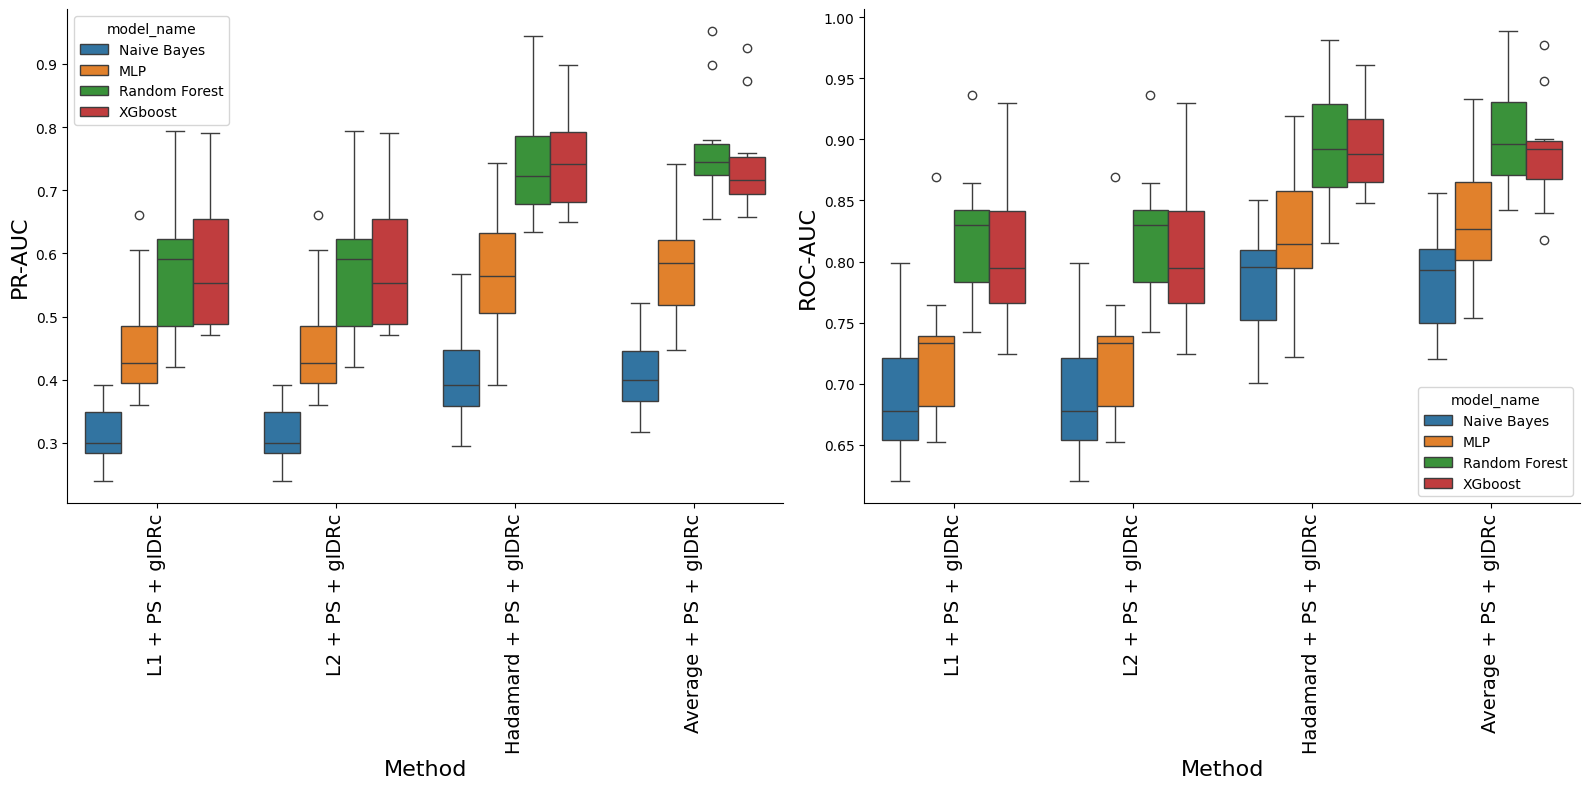


✅ Updated visualization saved as: model_emb_results_sorted_PR_AUC_ROC_AUC.png


In [85]:

results_model_list = [
    fold_metrics_xg_l1_df, fold_metrics_xg_l2_df, fold_metrics_xg_average_df, fold_metrics_xg_hadamard_df,
    fold_metrics_rf_l1_df, fold_metrics_rf_l2_df, fold_metrics_rf_average_df, fold_metrics_rf_hadamard_df,
    fold_metrics_nb_l1_df, fold_metrics_nb_l2_df, fold_metrics_nb_average_df, fold_metrics_nb_hadamard_df,
    fold_metrics_mlp_l1_df, fold_metrics_mlp_l2_df, fold_metrics_mlp_average_df, fold_metrics_mlp_hadamard_df,
]

# Concatenate all results
emd_results_df = pd.concat(results_model_list, ignore_index=True)
print(emd_results_df)
# Compute mean PR-AUC and mean ROC-AUC per model-method combination
mean_order_df = emd_results_df.groupby(['method', 'model_name']).agg(
    mean_pr_auc=('auc_pr', 'mean'),          # CHANGED: accuracy → pr_auc
    mean_roc_auc=('roc_auc', 'mean')         # RENAMED: mean_auc → mean_roc_auc for clarity
).reset_index()

model_order = ['Naive Bayes', "MLP", "Random Forest", "XGboost"]
method_order = ['L1 + PS + gIDRc', 'L2 + PS + gIDRc', 'Hadamard + PS + gIDRc', 'Average + PS + gIDRc']

# Sort model names by PR-AUC and ROC-AUC within each method
sorted_models_by_pr_auc = mean_order_df.sort_values(['method', 'mean_pr_auc']).groupby('method')['model_name'].apply(list).to_dict()
sorted_models_by_roc_auc = mean_order_df.sort_values(['method', 'mean_roc_auc']).groupby('method')['model_name'].apply(list).to_dict()

# Define a function to return the sorted hue order based on method
def get_hue_order(data, metric_order_dict):
    return sum([metric_order_dict[method] for method in data['method'].unique() if method in metric_order_dict], [])

# Set a blue-themed color palette
diverse_palette = sns.color_palette("tab10") 

plt.figure(figsize=(16, 8))

# SUBPLOT 1: PR-AUC (Previously Accuracy)
plt.subplot(1, 2, 1)
sns.boxplot(data=emd_results_df, x='method', y='auc_pr', hue='model_name',   
            hue_order=model_order, order=method_order, palette=diverse_palette)
plt.xticks(rotation=90, fontsize=14) 
plt.xlabel('Method', fontsize=16)
plt.ylabel('PR-AUC', fontsize=16)                                          
#plt.title('PR-AUC Performance by Method', fontsize=14)                      

# SUBPLOT 2: ROC-AUC (Unchanged)
plt.subplot(1, 2, 2)
sns.boxplot(data=emd_results_df, x='method', y='roc_auc', hue='model_name', 
            hue_order=model_order, order=method_order, palette=diverse_palette)
plt.xlabel('Method', fontsize=16)
plt.ylabel('ROC-AUC', fontsize=16)                                    ]
plt.xticks(rotation=90, fontsize=14)
#plt.title('ROC-AUC Performance by Method', fontsize=14)                      

sns.despine()
plt.tight_layout()
plt.savefig('model_emb_results_sorted_PR_AUC_ROC_AUC.png', dpi=300)         


# Create a summary table
summary_table = mean_order_df.pivot_table(
    index='model_name', 
    columns='method', 
    values=['mean_pr_auc', 'mean_roc_auc'], 
    aggfunc='mean'
)

print("\nMean PR-AUC by Model and Method:")
print(summary_table['mean_pr_auc'].round(4))

print("\nMean ROC-AUC by Model and Method:")
print(summary_table['mean_roc_auc'].round(4))



# Best models by PR-AUC
best_pr_auc = mean_order_df.loc[mean_order_df.groupby('method')['mean_pr_auc'].idxmax()]
print("\nBest models by PR-AUC for each method:")
for _, row in best_pr_auc.iterrows():
    print(f"  {row['method']}: {row['model_name']} (PR-AUC: {row['mean_pr_auc']:.4f})")

# Best models by ROC-AUC
best_roc_auc = mean_order_df.loc[mean_order_df.groupby('method')['mean_roc_auc'].idxmax()]
print("\nBest models by ROC-AUC for each method:")
for _, row in best_roc_auc.iterrows():
    print(f"  {row['method']}: {row['model_name']} (ROC-AUC: {row['mean_roc_auc']:.4f})")

# Overall best model
overall_best_pr_auc = mean_order_df.loc[mean_order_df['mean_pr_auc'].idxmax()]
overall_best_roc_auc = mean_order_df.loc[mean_order_df['mean_roc_auc'].idxmax()]

print(f"\nOverall best PR-AUC: {overall_best_pr_auc['model_name']} with {overall_best_pr_auc['method']} (PR-AUC: {overall_best_pr_auc['mean_pr_auc']:.4f})")
print(f"Overall best ROC-AUC: {overall_best_roc_auc['model_name']} with {overall_best_roc_auc['method']} (ROC-AUC: {overall_best_roc_auc['mean_roc_auc']:.4f})")



# Overall statistics
print(f"\nOverall PR-AUC Statistics:")
print(f"  Mean: {emd_results_df['auc_pr'].mean():.4f}")
print(f"  Std:  {emd_results_df['auc_pr'].std():.4f}")
print(f"  Min:  {emd_results_df['auc_pr'].min():.4f}")
print(f"  Max:  {emd_results_df['auc_pr'].max():.4f}")

print(f"\nOverall ROC-AUC Statistics:")
print(f"  Mean: {emd_results_df['roc_auc'].mean():.4f}")
print(f"  Std:  {emd_results_df['roc_auc'].std():.4f}")
print(f"  Min:  {emd_results_df['roc_auc'].min():.4f}")
print(f"  Max:  {emd_results_df['roc_auc'].max():.4f}")

# Model-wise statistics
print(f"\nPR-AUC by Model (mean ± std):")
model_pr_auc_stats = emd_results_df.groupby('model_name')['auc_pr'].agg(['mean', 'std'])
for model, stats in model_pr_auc_stats.iterrows():
    print(f"  {model:15}: {stats['mean']:.4f} ± {stats['std']:.4f}")

print(f"\nROC-AUC by Model (mean ± std):")
model_roc_auc_stats = emd_results_df.groupby('model_name')['roc_auc'].agg(['mean', 'std'])
for model, stats in model_roc_auc_stats.iterrows():
    print(f"  {model:15}: {stats['mean']:.4f} ± {stats['std']:.4f}")

plt.show()
print(f"\n✅ Updated visualization saved as: model_emb_results_sorted_PR_AUC_ROC_AUC.png")

In [87]:
import pandas as pd
from scipy import stats  # Add this import

# Define models and methods for comparison
models = ['XGboost', 'Random Forest', 'Naive Bayes', 'MLP']
methods = ['L1 + PS + gIDRc', 'L2 + PS + gIDRc', 'Average + PS + gIDRc', 'Hadamard + PS + gIDRc']

# Store results
results_roc_auc = []
results_pr_auc = []

# Loop through all model-method combinations
for model1 in models:
    for model2 in models:
        if model1 != model2:  # Avoid comparing the same model
            for method in methods:
                # Extract ROC AUC scores
                scores1_roc = emd_results_df[(emd_results_df['method'] == method) & (emd_results_df['model_name'] == model1)]['roc_auc']
                scores2_roc = emd_results_df[(emd_results_df['method'] == method) & (emd_results_df['model_name'] == model2)]['roc_auc']
                scores1_roc_mean = scores1_roc.mean()
                scores2_roc_mean = scores2_roc.mean()
                
                # Extract PR-AUC scores (note: column is 'auc_pr' not 'pr_auc')
                scores1_pr = emd_results_df[(emd_results_df['method'] == method) & (emd_results_df['model_name'] == model1)]['auc_pr']
                scores2_pr = emd_results_df[(emd_results_df['method'] == method) & (emd_results_df['model_name'] == model2)]['auc_pr']
                scores1_pr_mean = scores1_pr.mean()
                scores2_pr_mean = scores2_pr.mean()
                
                # Perform Mann-Whitney U test for ROC AUC
                if not scores1_roc.empty and not scores2_roc.empty:
                    stat_roc, p_roc = stats.mannwhitneyu(scores1_roc, scores2_roc, alternative='two-sided')
                    results_roc_auc.append([method, model1, model2, scores1_roc_mean, scores2_roc_mean, stat_roc, p_roc])
                
                # Perform Mann-Whitney U test for PR-AUC
                if not scores1_pr.empty and not scores2_pr.empty:
                    stat_pr, p_pr = stats.mannwhitneyu(scores1_pr, scores2_pr, alternative='two-sided')
                    results_pr_auc.append([method, model1, model2, scores1_pr_mean, scores2_pr_mean, stat_pr, p_pr])

# Convert results to DataFrame for better visualization
pm_roc_auc_df = pd.DataFrame(results_roc_auc, columns=['Method', 'Model_1', 'Model_2', 'Model_1_mean_roc', 'Model_2_mean_roc', 'U_Statistic', 'P_Value'])
pm_pr_auc_df = pd.DataFrame(results_pr_auc, columns=['Method', 'Model_1', 'Model_2', 'Model_1_mean_pr_auc', 'Model_2_mean_pr_auc', 'U_Statistic', 'P_Value'])

# Save individual results
pm_roc_auc_df.to_csv("../protien_embedding_combination_roc_results.csv", index=None)
pm_pr_auc_df.to_csv("../protien_embedding_combination_pr_auc_results.csv", index=None)

# Merge ROC AUC and PR-AUC results
pm_combined_df = pd.merge(
    pm_roc_auc_df,
    pm_pr_auc_df,
    on=['Method', 'Model_1', 'Model_2'],
    suffixes=('_roc', '_pr_auc')
)

# Save the combined results
pm_combined_df.to_csv("../output/protien_embedding_combination_results.csv", index=False)

In [88]:
labels = delta_emb_df['Class']
y = labels
y_encoded = (labels == 'Deleterious').astype(int)
scaler = StandardScaler()

#print("Original labels:", np.unique(labels))
#print("Encoded labels:", np.unique(y_encoded))
#print("Fixed label mapping:")
for orig_label in np.unique(labels):
    # Fix: Use .iloc[0] instead of [0] to get the first value
    mask = (labels == orig_label)
    encoded_val = y_encoded[mask].iloc[0]
#    print(f"  {orig_label} -> {encoded_val}")



xg_best_params, xg_trial_df, xg_test_results, train_val_indices, test_indices, xg_test_pred_proba, xg_test_summary = train_optimize_xgboost(average_X, y_encoded, 'default')


[I 2025-08-06 00:53:38,122] A new study created in memory with name: no-name-ec781663-0464-4714-ae12-f1bc27d7a155
[I 2025-08-06 00:53:39,982] Trial 0 finished with value: 0.6220942407997506 and parameters: {'n_estimators': 124, 'max_depth': 9, 'learning_rate': 0.061391674053479846, 'colsample_bytree': 0.6887837186762122, 'subsample': 0.5360985577504385, 'gamma': 2.392499453748749, 'min_child_weight': 8, 'reg_alpha': 9.06648955732017, 'reg_lambda': 3.4333797166359084}. Best is trial 0 with value: 0.6220942407997506.
[I 2025-08-06 00:53:42,863] Trial 1 finished with value: 0.6756640145395665 and parameters: {'n_estimators': 210, 'max_depth': 6, 'learning_rate': 0.15172730007489194, 'colsample_bytree': 0.8121420702417372, 'subsample': 0.6641370555922868, 'gamma': 0.7481236149285325, 'min_child_weight': 8, 'reg_alpha': 3.6027073208132077, 'reg_lambda': 4.034829808404053}. Best is trial 1 with value: 0.6756640145395665.
[I 2025-08-06 00:53:44,642] Trial 2 finished with value: 0.684250784229


Best hyperparameters found (optimized for PR-AUC):
 {'n_estimators': 303, 'max_depth': 7, 'learning_rate': 0.1286134749672217, 'colsample_bytree': 0.7916599660057819, 'subsample': 0.7339279992538008, 'gamma': 0.06943388635552344, 'min_child_weight': 1, 'reg_alpha': 0.4856662241344346, 'reg_lambda': 1.5847233650044932, 'tree_method': 'gpu_hist'}

Best trial cross-validation results (optimized for PR-AUC):
PR-AUC:  0.7377 ± 0.0620
ROC-AUC: 0.8858 ± 0.0381
Accuracy: 0.9133 ± 0.0148

Test Set Performance:
PR-AUC:  0.8000
ROC-AUC: 0.9275
Accuracy: 0.9240
Test samples: 421
Class distribution: {'negative': 358, 'positive': 63}


In [89]:
optuna_train_df = delta_emb_df.iloc[train_val_indices].copy()
optuna_test_df = delta_emb_df.iloc[test_indices].copy()
optuna_train_df.to_csv("../output/none_training_data.csv", index=False)
optuna_test_df['model_pred'] = 1 - xg_test_pred_proba
optuna_test_df.to_csv("../output/none_test_data.csv", index=False)

true_labels_test = y_encoded[test_indices]
roc_auc_score(true_labels_test, xg_test_pred_proba)


0.9274629777423072

In [90]:

average_eve_standardized_features = scaler.fit_transform(delta_eve_emb_average_df)
average_eve_standardized_features_df = pd.DataFrame(average_eve_standardized_features, columns=delta_eve_emb_average_df.columns)
average_eve_X = average_eve_standardized_features_df.apply(pd.to_numeric, errors='coerce')

eve_xg_best_params, eve_xg_train_df, eve_xg_test_results, eve_train_val_indices, eve_test_indices, eve_test_pred_proba, eve_model_summary = train_optimize_xgboost(average_eve_X, y_encoded, 'EVE')
eve_optuna_train_df = average_eve_X.loc[eve_train_val_indices]  
eve_optuna_test_df = average_eve_X.loc[eve_test_indices]       

eve_optuna_train_df.to_csv("../output/EVE_training_data.csv", index=False)
eve_optuna_test_df['eve_model'] = eve_test_pred_proba
eve_optuna_test_df.to_csv("../output/EVE_test_data.csv", index=False)



[I 2025-08-06 01:09:04,009] A new study created in memory with name: no-name-fc0fa5d8-145f-4e8a-ab20-10218b8b6310
[I 2025-08-06 01:09:13,494] Trial 0 finished with value: 0.7748798169224896 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2242435808247071, 'colsample_bytree': 0.9342205853333221, 'subsample': 0.9742008491465822, 'gamma': 4.362663063244129, 'min_child_weight': 5, 'reg_alpha': 3.787776262834149, 'reg_lambda': 9.52653865839226}. Best is trial 0 with value: 0.7748798169224896.
[I 2025-08-06 01:09:25,886] Trial 1 finished with value: 0.7778563067566006 and parameters: {'n_estimators': 205, 'max_depth': 6, 'learning_rate': 0.2279745044104897, 'colsample_bytree': 0.5227763498352274, 'subsample': 0.9257717591458774, 'gamma': 2.8988937378017168, 'min_child_weight': 5, 'reg_alpha': 2.968181427885054, 'reg_lambda': 3.3268091607506034}. Best is trial 1 with value: 0.7778563067566006.
[I 2025-08-06 01:09:44,377] Trial 2 finished with value: 0.7765899849597229


Best hyperparameters found (optimized for PR-AUC):
 {'n_estimators': 466, 'max_depth': 10, 'learning_rate': 0.029402699929132255, 'colsample_bytree': 0.8637202572416792, 'subsample': 0.6020739179562226, 'gamma': 0.8779759795376679, 'min_child_weight': 1, 'reg_alpha': 0.3812982842112633, 'reg_lambda': 7.6671224776891576, 'tree_method': 'gpu_hist'}

Best trial cross-validation results (optimized for PR-AUC):
PR-AUC:  0.8132 ± 0.0636
ROC-AUC: 0.9198 ± 0.0345
Accuracy: 0.9305 ± 0.0152

Test Set Performance:
PR-AUC:  0.9185
ROC-AUC: 0.9651
Accuracy: 0.9572
Test samples: 421
Class distribution: {'negative': 358, 'positive': 63}


In [91]:
metadata_columns = ['AlphaMissense_rankscore', 'ESM1b_rankscore', 'EVE_rankscore',
       'mutation', 'Class', 'WT', 'abs_delta_asphericity',
       'abs_delta_radius_of_gyration', 'abs_delta_end_to_end_distance',
       'abs_delta_scaling_exponent', 'abs_delta_prefactor',
       'integrated_fitCons_rankscore', 'GM12878_fitCons_rankscore',
       'H1-hESC_fitCons_rankscore', 'HUVEC_fitCons_rankscore',
       'LINSIGHT_rankscore', 'GERP++_RS_rankscore',
       'GERP_91_mammals_rankscore', 'phyloP100way_vertebrate_rankscore',
       'phyloP470way_mammalian_rankscore', 'phyloP17way_primate_rankscore',
       'phastCons100way_vertebrate_rankscore',
       'phastCons470way_mammalian_rankscore',
       'phastCons17way_primate_rankscore', 'SiPhy_29way_logOdds_rankscore',
       'bStatistic_converted_rankscore', 'label', 'size']  # Specify which columns you want
available_metadata_cols = [col for col in metadata_columns if col in delta_emb_df.columns]

for col in available_metadata_cols:
    eve_optuna_train_df[col] = delta_emb_df.loc[eve_train_val_indices, col]
    eve_optuna_test_df[col] = delta_emb_df.loc[eve_test_indices, col]


eve_optuna_test_df['eve_model'] = eve_test_pred_proba

# Save to CSV
eve_optuna_train_df.to_csv("../output/EVE_training_data.new.csv", index=False)
eve_optuna_test_df.to_csv("../output/EVE_test_data.new.csv", index=False)



In [92]:
average_esm_standardized_features = scaler.fit_transform(delta_esm_emb_average_df)
average_esm_standardized_features_df = pd.DataFrame(
    average_esm_standardized_features, 
    columns=delta_esm_emb_average_df.columns,
    index=delta_esm_emb_average_df.index  # ✅ Preserve index
)
average_esm_X = average_esm_standardized_features_df.apply(pd.to_numeric, errors='coerce')

# Train model
esm_xg_best_params, esm_xg_train_df, esm_xg_test_results, esm_train_val_indices, esm_test_indices, esm_test_pred_proba, esm_model_summary = train_optimize_xgboost(average_esm_X, y_encoded, 'ESM1B')

esm_optuna_train_df = average_esm_X.loc[esm_train_val_indices] 
esm_optuna_test_df = average_esm_X.loc[esm_test_indices]       

esm_optuna_train_df.to_csv("../output/ESM1b_training_data.csv", index=False)
esm_optuna_test_df['esm1b_model'] = esm_test_pred_proba
esm_optuna_test_df.to_csv("../output/ESM1b_test_data.csv", index=False)

[I 2025-08-06 01:53:57,111] A new study created in memory with name: no-name-91f43f5d-de1c-419a-8197-5e010938a327
[I 2025-08-06 01:54:07,119] Trial 0 finished with value: 0.8203647146659927 and parameters: {'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.19796516847856177, 'colsample_bytree': 0.841326720425642, 'subsample': 0.5505206687485981, 'gamma': 0.8672416837304442, 'min_child_weight': 7, 'reg_alpha': 5.2231046936918, 'reg_lambda': 5.0730979259903854}. Best is trial 0 with value: 0.8203647146659927.
[I 2025-08-06 01:54:17,571] Trial 1 finished with value: 0.8249466500535476 and parameters: {'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.1779473305839511, 'colsample_bytree': 0.7375183940958216, 'subsample': 0.9220332986638827, 'gamma': 2.4997819249153963, 'min_child_weight': 3, 'reg_alpha': 2.601041212498869, 'reg_lambda': 3.930186356611115}. Best is trial 1 with value: 0.8249466500535476.
[I 2025-08-06 01:54:33,450] Trial 2 finished with value: 0.8318382297999196


Best hyperparameters found (optimized for PR-AUC):
 {'n_estimators': 330, 'max_depth': 10, 'learning_rate': 0.07711812705171235, 'colsample_bytree': 0.7729948664986579, 'subsample': 0.505278766873306, 'gamma': 0.6247587410697344, 'min_child_weight': 3, 'reg_alpha': 1.68043147935869, 'reg_lambda': 5.1450776731729455, 'tree_method': 'gpu_hist'}

Best trial cross-validation results (optimized for PR-AUC):
PR-AUC:  0.8408 ± 0.0404
ROC-AUC: 0.9255 ± 0.0311
Accuracy: 0.9400 ± 0.0094

Test Set Performance:
PR-AUC:  0.8772
ROC-AUC: 0.9659
Accuracy: 0.9382
Test samples: 421
Class distribution: {'negative': 358, 'positive': 63}


In [93]:
for col in available_metadata_cols:
    esm_optuna_train_df[col] = delta_emb_df.loc[esm_train_val_indices, col]
    esm_optuna_test_df[col] = delta_emb_df.loc[esm_test_indices, col]


esm_optuna_test_df['esm_model'] = esm_test_pred_proba

# Save to CSV
esm_optuna_train_df.to_csv("../output/ESM_training_data.new.csv", index=False)
esm_optuna_test_df.to_csv("../output/ESM_test_data.new.csv", index=False)



In [94]:


average_am_standardized_features = scaler.fit_transform(delta_am_emb_average_df)
average_am_standardized_features_df = pd.DataFrame(
    average_am_standardized_features, 
    columns=delta_am_emb_average_df.columns,
    index=delta_am_emb_average_df.index  # ✅ Preserve index
)
average_am_X = average_am_standardized_features_df.apply(pd.to_numeric, errors='coerce')

# Train model
am_xg_best_params, am_xg_train_df, am_xg_test_results, am_train_val_indices, am_test_indices, am_test_pred_proba, am_summary = train_optimize_xgboost(average_am_X, y_encoded, 'AlphaMissense')

# Fix: Use the actual training data (standardized features)
am_optuna_train_df = average_am_X.loc[am_train_val_indices]  # ✅ Correct dataset!
am_optuna_test_df = average_am_X.loc[am_test_indices]        # ✅ Correct dataset

am_optuna_test_df['model_pred'] = am_test_pred_proba

# Save with correct spelling
am_optuna_train_df.to_csv("../output/AlphaMissense_training_data.csv", index=False)  # ✅ Fixed spelling!
am_optuna_test_df.to_csv("../output/AlphaMissense_test_data.csv", index=False)  




[I 2025-08-06 02:38:57,452] A new study created in memory with name: no-name-d65df0c5-14e6-408c-95ee-839a460047d3
[I 2025-08-06 02:39:06,874] Trial 0 finished with value: 0.8428113025951708 and parameters: {'n_estimators': 102, 'max_depth': 4, 'learning_rate': 0.050251277363311725, 'colsample_bytree': 0.7082397154694955, 'subsample': 0.7461409555685583, 'gamma': 3.3085593734019354, 'min_child_weight': 5, 'reg_alpha': 2.754002770068081, 'reg_lambda': 0.3530466192700721}. Best is trial 0 with value: 0.8428113025951708.
[I 2025-08-06 02:39:20,387] Trial 1 finished with value: 0.8332366916908989 and parameters: {'n_estimators': 297, 'max_depth': 7, 'learning_rate': 0.05277927891957604, 'colsample_bytree': 0.5801834849887275, 'subsample': 0.7929159711448772, 'gamma': 3.8722360445019004, 'min_child_weight': 1, 'reg_alpha': 8.5171814276402, 'reg_lambda': 9.167054934639873}. Best is trial 0 with value: 0.8428113025951708.
[I 2025-08-06 02:39:34,756] Trial 2 finished with value: 0.8267290760881


Best hyperparameters found (optimized for PR-AUC):
 {'n_estimators': 390, 'max_depth': 3, 'learning_rate': 0.06837077754944737, 'colsample_bytree': 0.8317999086915758, 'subsample': 0.5959144159402869, 'gamma': 1.5067385213122697, 'min_child_weight': 1, 'reg_alpha': 1.1234509977194538, 'reg_lambda': 1.1927768481201761, 'tree_method': 'gpu_hist'}

Best trial cross-validation results (optimized for PR-AUC):
PR-AUC:  0.8634 ± 0.0458
ROC-AUC: 0.9424 ± 0.0297
Accuracy: 0.9364 ± 0.0127

Test Set Performance:
PR-AUC:  0.9310
ROC-AUC: 0.9833
Accuracy: 0.9644
Test samples: 421
Class distribution: {'negative': 358, 'positive': 63}


In [95]:
for col in available_metadata_cols:
    am_optuna_train_df[col] = delta_emb_df.loc[am_train_val_indices, col]
    am_optuna_test_df[col] = delta_emb_df.loc[am_test_indices, col]


am_optuna_test_df['AFM_model'] = am_test_pred_proba

# Save to CSV
am_optuna_train_df.to_csv("../output/AlphaMissense_training_data.new.csv", index=False)
am_optuna_test_df.to_csv("../output/AlphaMissense_test_data.new.csv", index=False)

print(f"Training data shape: {am_optuna_train_df.shape}")
print(f"Test data shape: {am_optuna_test_df.shape}")
#print(f"Columns in test data: {list(am_optuna_test_df.columns)}")

Training data shape: (1683, 1090)
Test data shape: (421, 1092)


In [96]:

model_test_output_df = optuna_test_df[['AlphaMissense_rankscore','ESM1b_rankscore', 'EVE_rankscore', 'GENES',	
                                       'mutation', 'Class', 'label', 'model_pred']]
model_test_output_df['model_pred'] = 1- model_test_output_df['model_pred']
model_test_output_df['AlphaMissense_enhanced'] = am_optuna_test_df['AFM_model']
model_test_output_df['ESM1b_enhanced'] = esm_optuna_test_df['esm_model']
model_test_output_df['EVE_enhanced'] = eve_optuna_test_df['eve_model']

,AlphaMissense_rankscore,ESM1b_rankscore,EVE_rankscore,GENES,mutation,Class,label,model_pred,AlphaMissense_enhanced,ESM1b_enhanced,EVE_enhanced
1692,0.04356,0.30362,0.01065,PRLR,G551R,Neutral,0,0.067339,0.026387,0.023858,0.073386
198,0.16187,0.19112,0.00000,EHMT1,Q17K,Neutral,0,0.000120,0.000717,0.000619,0.001247
558,0.93569,0.44566,0.85991,CTNNB1,S45F,Deleterious,1,0.998135,0.992955,0.978438,0.993968
99,0.19720,0.28302,0.21770,EHMT1,A196V,Neutral,0,0.000323,0.000860,0.000503,0.001432
689,0.97009,0.69488,0.67547,CDKN1C,F265S,Deleterious,1,0.565020,0.921712,0.897971,0.887472
...,...,...,...,...,...,...,...,...,...,...,...
1984,0.00114,0.04254,0.00000,VEGFB,T183A,Neutral,0,0.019985,0.005272,0.017520,0.024575
935,0.97949,0.97690,0.00000,FGF13,R11P,Deleterious,1,0.502284,0.986218,0.945178,0.922702
1774,0.12512,0.00000,0.00000,NPPA,V32M,Neutral,0,0.008416,0.007849,0.008668,0.017281
890,0.23883,0.63102,0.23461,MECP2,T215M,Neutral,0,0.340368,0.022382,0.485366,0.078683


In [116]:
xg_trial_df = pd.read_json("xgboost_results/default_optuna_trials_detailed.json")
eve_xg_train_df =  pd.read_json("xgboost_results/EVE_optuna_trials_detailed.json")
esm_xg_train_df = pd.read_json("xgboost_results/ESM1B_optuna_trials_detailed.json")
am_xg_train_df = pd.read_json("xgboost_results/AlphaMissense_optuna_trials_detailed.json")
xg_trial_df.to_csv("../output/optuna_model_results_hpo.csv", index=False)                               

,trial_number,params,roc_auc_scores,accuracy_scores,pr_auc_scores,mean_roc_auc,mean_accuracy,mean_pr_auc,mean_score
0,0,"{'n_estimators': 124, 'max_depth': 9, 'learnin...","[0.7479827864, 0.8746637977, 0.8657880581, 0.8...","[0.8698224852, 0.8816568047000001, 0.917159763...","[0.48517946370000004, 0.6355156938000001, 0.72...",0.846354,0.887102,0.622094,0.622094
1,1,"{'n_estimators': 210, 'max_depth': 6, 'learnin...","[0.7684238838, 0.8821947283, 0.891877353400000...","[0.8816568047000001, 0.8994082840000001, 0.911...","[0.49810124100000003, 0.7058019281, 0.73689231...",0.862837,0.902564,0.675664,0.675664
2,2,"{'n_estimators': 96, 'max_depth': 8, 'learning...","[0.7654653039, 0.8994082840000001, 0.894835933...","[0.8816568047000001, 0.8994082840000001, 0.917...","[0.5380197659, 0.7151338892, 0.7636773244, 0.7...",0.867719,0.900775,0.684251,0.684251
3,3,"{'n_estimators': 464, 'max_depth': 4, 'learnin...","[0.7372243141, 0.8496503497000001, 0.880715438...","[0.875739645, 0.875739645, 0.9289940828000001,...","[0.4733783138, 0.6157651495, 0.752532386100000...",0.847332,0.896024,0.632260,0.632260
4,4,"{'n_estimators': 336, 'max_depth': 7, 'learnin...","[0.7434104357, 0.8811188811, 0.8813878429, 0.8...","[0.8816568047000001, 0.8934911243, 0.917159763...","[0.4915783562, 0.6594151046000001, 0.727232887...",0.850746,0.901374,0.644994,0.644994
...,...,...,...,...,...,...,...,...,...
145,145,"{'n_estimators': 294, 'max_depth': 7, 'learnin...","[0.7899408284, 0.8854222700000001, 0.920118343...","[0.8698224852, 0.9230769231, 0.9230769231, 0.9...","[0.5817110448, 0.7584284837, 0.800283652000000...",0.878737,0.913264,0.725741,0.725741
146,146,"{'n_estimators': 314, 'max_depth': 7, 'learnin...","[0.7867132867000001, 0.8983324368000001, 0.910...","[0.8816568047000001, 0.9171597633, 0.923076923...","[0.5812787415, 0.7664334115, 0.7923487499, 0.7...",0.882315,0.912070,0.727634,0.727634
147,147,"{'n_estimators': 315, 'max_depth': 7, 'learnin...","[0.7705755783, 0.8786982249, 0.8967186659, 0.8...","[0.8816568047000001, 0.9053254438, 0.923076923...","[0.5611948873, 0.7267599362, 0.7633147011, 0.7...",0.883159,0.910887,0.729246,0.729246
148,148,"{'n_estimators': 280, 'max_depth': 8, 'learnin...","[0.783485745, 0.9037116729, 0.9174287251000001...","[0.8816568047000001, 0.9230769231, 0.928994082...","[0.5870949262, 0.7753794770000001, 0.786098184...",0.885302,0.910873,0.730061,0.730061


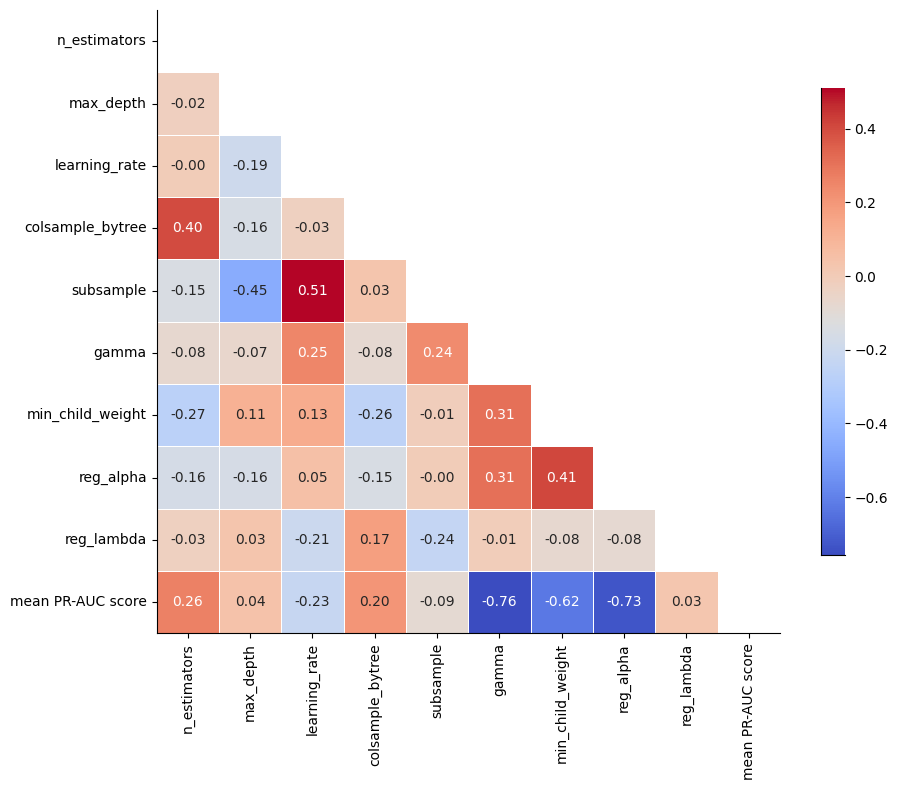

In [118]:


params_df = pd.DataFrame(xg_trial_df['params'].tolist())

# Concatenate with original DataFrame (excluding the old 'params' column)
df_expanded = pd.concat([params_df, xg_trial_df['mean_score']], axis=1)
df_expanded = pd.concat([params_df, xg_trial_df.rename(columns={'mean_score': 'mean PR-AUC score'})['mean PR-AUC score']], axis=1)
corr_matrix = df_expanded.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Define a colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with annotation
sns.heatmap(
    corr_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f",
    square=True, linewidths=0.5, cbar_kws={"shrink": 0.75}
)

# Highlight correlations with mean_score
\
sns.despine()
plt.tight_layout()
plt.savefig('optuna_figure_hpo.png', dpi=300)
plt.show()
#df_expanded

In [103]:
esm_best_idx = esm_xg_train_df['mean_score'].idxmax()
eve_best_idx = eve_xg_train_df['mean_score'].idxmax()
am_best_idx = am_xg_train_df['mean_score'].idxmax()
def_best_idx = xg_trial_df['mean_score'].idxmax()
#print(esm_xg_train_df)
# Debug: Check data types
print("ESM fold_scores type:", type(esm_xg_train_df.loc[esm_best_idx, 'pr_auc_scores']))
print("ESM fold_scores content:", esm_xg_train_df.loc[esm_best_idx, 'pr_auc_scores'])

# Function to safely extract scores
def extract_scores(df, idx, score_col):
    """Safely extract and convert scores to list"""
    scores = df.loc[idx, score_col]
    
    # Handle different data types
    if isinstance(scores, str):
        # If it's a string representation of a list
        try:
            import ast
            scores = ast.literal_eval(scores)
        except:
            print(f"Error parsing {score_col} as string")
            return []
    elif isinstance(scores, (list, tuple, np.ndarray)):
        scores = list(scores)
    else:
        print(f"Unexpected type for {score_col}: {type(scores)}")
        return []
    
    return scores

# Extract scores safely
esm_auc_scores_scores = extract_scores(esm_xg_train_df, esm_best_idx, 'roc_auc_scores')
esm_accuracy_scores = extract_scores(esm_xg_train_df, esm_best_idx, 'accuracy_scores')
esm_accuracy_scores = extract_scores(esm_xg_train_df, esm_best_idx, 'pr_auc_scores')

eve_auc_scores_scores = extract_scores(eve_xg_train_df, eve_best_idx, 'roc_auc_scores')
eve_accuracy_scores = extract_scores(eve_xg_train_df, eve_best_idx, 'accuracy_scores')
eve_pr_auc_scores = extract_scores(eve_xg_train_df, eve_best_idx, 'pr_auc_scores')

am_auc_scores_scores = extract_scores(am_xg_train_df, am_best_idx, 'roc_auc_scores')
am_accuracy_scores = extract_scores(am_xg_train_df, am_best_idx, 'accuracy_scores')
am_pr_auc_scores = extract_scores(am_xg_train_df, am_best_idx, 'pr_auc_scores')

def_auc_scores_scores = extract_scores(xg_trial_df, def_best_idx, 'roc_auc_scores')
def_accuracy_scores = extract_scores(xg_trial_df, def_best_idx, 'accuracy_scores')
def_pr_auc_scores = extract_scores(am_xg_train_df, am_best_idx, 'pr_auc_scores')



ESM fold_scores type: <class 'list'>
ESM fold_scores content: [0.7946961852000001, 0.8340789692, 0.8590157485000001, 0.878865913, 0.8340222597, 0.8059268785, 0.8851125208, 0.8765613541, 0.7608126676, 0.8788947914]


[0.6986573775,
 0.7341892832,
 0.9018420391,
 0.8275054522,
 0.8377322708,
 0.7838523885,
 0.8796527161000001,
 0.8484051133,
 0.7557261633,
 0.8640515629000001]

In [104]:
# Create DataFrames
fold_scores_esm_optuna_df = pd.DataFrame({
    'roc_auc': esm_auc_scores_scores,
    'accuracy': esm_accuracy_scores,
    'pr_auc': esm_accuracy_scores
})
fold_scores_esm_optuna_df['fold'] = range(len(esm_auc_scores_scores))
fold_scores_esm_optuna_df['method'] = 'ESM1B + Average + PS + gIDRc'
fold_scores_esm_optuna_df['model_name'] = "XGboost/Optuna"

fold_scores_eve_optuna_df = pd.DataFrame({
    'roc_auc': eve_auc_scores_scores,
    'accuracy': eve_accuracy_scores,
    'pr_auc': eve_pr_auc_scores
})
fold_scores_eve_optuna_df['fold'] = range(len(eve_auc_scores_scores))
fold_scores_eve_optuna_df['method'] = 'EVE + Average + PS + gIDRc'
fold_scores_eve_optuna_df['model_name'] = "XGboost/Optuna"

fold_scores_am_optuna_df = pd.DataFrame({
    'roc_auc': am_auc_scores_scores,
    'accuracy': am_accuracy_scores,
    'pr_auc':am_pr_auc_scores,
})
fold_scores_am_optuna_df['fold'] = range(len(am_auc_scores_scores))
fold_scores_am_optuna_df['method'] = 'AlphaMissense + Average + PS + gIDRc'
fold_scores_am_optuna_df['model_name'] = "XGboost/Optuna"

fold_scores_def_optuna_df = pd.DataFrame({
    'roc_auc': def_auc_scores_scores,
    'accuracy': def_accuracy_scores,
    'pr_auc': def_pr_auc_scores,
})
fold_scores_def_optuna_df['fold'] = range(len(def_auc_scores_scores))
fold_scores_def_optuna_df['method'] = 'Average + PS + gIDRc'
fold_scores_def_optuna_df['model_name'] = "XGboost/Optuna"
#print(fold_scores_eve_optuna_df)
# Print means
print(f"Default AUC mean: {fold_scores_def_optuna_df['roc_auc'].mean():.4f}")
print(f"EVE AUC mean: {fold_scores_eve_optuna_df['roc_auc'].mean():.4f}")
print(f"AlphaMissense AUC mean: {fold_scores_am_optuna_df['roc_auc'].mean():.4f}")

print(f"Default accuracy mean: {fold_scores_def_optuna_df['accuracy'].mean():.4f}")
print(f"EVE accuracy mean: {fold_scores_eve_optuna_df['accuracy'].mean():.4f}")
print(f"ESM accuracy mean: {fold_scores_esm_optuna_df['accuracy'].mean():.4f}")
print(f"AlphaMissense accuracy mean: {fold_scores_am_optuna_df['accuracy'].mean():.4f}")

print(f"Default pr_auc mean: {fold_scores_def_optuna_df['pr_auc'].mean():.4f}")
print(f"EVE pr_auc mean: {fold_scores_eve_optuna_df['pr_auc'].mean():.4f}")
print(f"ESM pr_auc mean: {fold_scores_esm_optuna_df['pr_auc'].mean():.4f}")
print(f"AlphaMissense pr_auc mean: {fold_scores_am_optuna_df['pr_auc'].mean():.4f}")

Default AUC mean: 0.8858
EVE AUC mean: 0.9198
AlphaMissense AUC mean: 0.9424
Default accuracy mean: 0.9133
EVE accuracy mean: 0.9305
ESM accuracy mean: 0.8408
AlphaMissense accuracy mean: 0.9364
Default pr_auc mean: 0.8634
EVE pr_auc mean: 0.8132
ESM pr_auc mean: 0.8408
AlphaMissense pr_auc mean: 0.8634


In [105]:
def calculate_cv_confidence_intervals(result_df):
    """
    Calculate 95% confidence intervals for 10-fold cross-validation results
    """
    print("=== 10-FOLD CROSS-VALIDATION CONFIDENCE INTERVALS ===\n")
    
    # Group by method and calculate statistics
    methods = result_df['method'].unique()
    
    results_summary = []
    
    for method in methods:
        method_data = result_df[result_df['method'] == method]
        
        # Get fold values
        auc_values = method_data['roc_auc'].values
        pr_auc_values = method_data['pr_auc'].values  # Changed from accuracy to pr_auc
        
        if len(auc_values) == 0:
            continue
            
        # Calculate statistics for AUC
        auc_mean = np.mean(auc_values)
        auc_std = np.std(auc_values, ddof=1)  # Sample standard deviation
        auc_sem = stats.sem(auc_values)  # Standard error of mean
        n_folds = len(auc_values)
        
        # 95% CI using t-distribution
        auc_ci = stats.t.interval(0.95, n_folds-1, loc=auc_mean, scale=auc_sem)
        
        # Calculate statistics for PR-AUC (changed from Accuracy)
        pr_auc_mean = np.mean(pr_auc_values)
        pr_auc_std = np.std(pr_auc_values, ddof=1)
        pr_auc_sem = stats.sem(pr_auc_values)
        pr_auc_ci = stats.t.interval(0.95, n_folds-1, loc=pr_auc_mean, scale=pr_auc_sem)
        
        print(f"Method: {method}")
        print(f"  Sample size: {n_folds} folds")
        print(f"  AUC:      {auc_mean:.4f} ± {auc_sem:.4f}")
        print(f"            95% CI: [{auc_ci[0]:.4f}, {auc_ci[1]:.4f}] (width: {auc_ci[1]-auc_ci[0]:.4f})")
        print(f"  PR-AUC:   {pr_auc_mean:.4f} ± {pr_auc_sem:.4f}")  # Changed label
        print(f"            95% CI: [{pr_auc_ci[0]:.4f}, {pr_auc_ci[1]:.4f}] (width: {pr_auc_ci[1]-pr_auc_ci[0]:.4f})")
        print("-" * 80)
        
        results_summary.append({
            'method': method,
            'n_folds': n_folds,
            'auc_mean': auc_mean,
            'auc_std': auc_std,
            'auc_sem': auc_sem,
            'auc_ci_lower': auc_ci[0],
            'auc_ci_upper': auc_ci[1],
            'auc_ci_width': auc_ci[1] - auc_ci[0],
            'pr_auc_mean': pr_auc_mean,          # Changed from acc_mean
            'pr_auc_std': pr_auc_std,            # Changed from acc_std
            'pr_auc_sem': pr_auc_sem,            # Changed from acc_sem
            'pr_auc_ci_lower': pr_auc_ci[0],     # Changed from acc_ci_lower
            'pr_auc_ci_upper': pr_auc_ci[1],     # Changed from acc_ci_upper
            'pr_auc_ci_width': pr_auc_ci[1] - pr_auc_ci[0]  # Changed from acc_ci_width
        })
    
    return pd.DataFrame(results_summary)

def compare_methods_significance(result_df, method1, method2, metric='roc_auc'):
    """
    Compare two methods for statistical significance using paired t-test
    (since they're evaluated on the same CV folds)
    """
    data1 = result_df[result_df['method'] == method1][metric].values
    data2 = result_df[result_df['method'] == method2][metric].values
    
    if len(data1) != len(data2):
        print(f"Warning: Different number of folds for {method1} ({len(data1)}) vs {method2} ({len(data2)})")
        min_len = min(len(data1), len(data2))
        data1 = data1[:min_len]
        data2 = data2[:min_len]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(data1, data2)
    
    mean_diff = np.mean(data1) - np.mean(data2)
    
    print(f"\nPaired t-test: {method1} vs {method2} ({metric.upper()})")
    print(f"Mean difference: {mean_diff:+.4f}")
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Significant: {'YES' if p_value < 0.05 else 'NO'}")
    
    return {'mean_diff': mean_diff, 't_stat': t_stat, 'p_value': p_value, 'significant': p_value < 0.05}

In [106]:
noemb_results = 'results_noemb_results.initial.multiple_models.csv'
noemb_results_df = pd.read_csv(noemb_results)

# Filter and standardize column names
model_to_keep = ['AlphaMissense', 'EVE', 'ESM1B']
noemb_results_df = noemb_results_df[noemb_results_df['model'].isin(model_to_keep)]
noemb_results_df = noemb_results_df[['fold', 'auc','pr_auc', 'accuracy', 'method', 'model']].copy()
noemb_results_df.columns = ['fold', 'roc_auc', 'pr_auc', 'accuracy', 'method', 'model_name']

Data cleaning summary:
Total rows before cleaning: 70
Total rows after removing NaN: 70

Method distribution:
EVE                                     10
ESM1B                                   10
AlphaMissense                           10
Average + PS + gIDRc                    10
EVE + Average + PS + gIDRc              10
ESM1B + Average + PS + gIDRc            10
AlphaMissense + Average + PS + gIDRc    10
Name: method, dtype: int64
Total rows after numeric conversion: 70


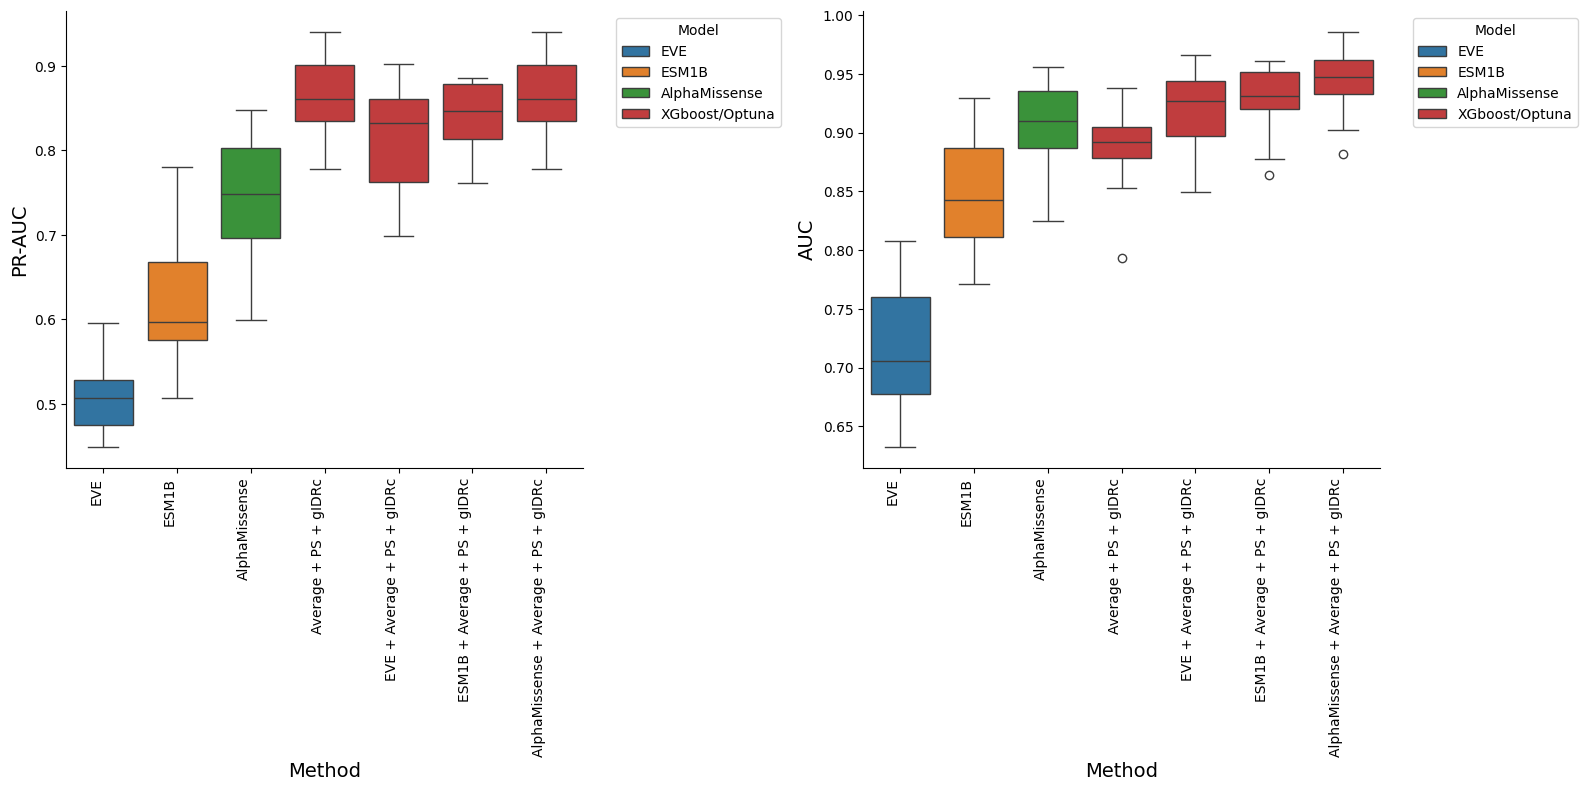

In [107]:


# Fix: Ensure method names match exactly with what you'll use in comparisons
noemb_results_df['method'] = noemb_results_df['method'].replace({
    'AlphaMissense': 'AlphaMissense',
    'EVE': 'EVE', 
    'ESM1B': 'ESM1B'
})

# Combine all results
result_all_df = pd.concat([
    noemb_results_df, 
    fold_scores_def_optuna_df, 
    fold_scores_eve_optuna_df, 
    fold_scores_esm_optuna_df, 
    fold_scores_am_optuna_df
], axis=0, ignore_index=True)

# Fix: Clean the data
print("Data cleaning summary:")
print(f"Total rows before cleaning: {len(result_all_df)}")

# Remove rows with NaN values in key columns
result_all_df = result_all_df.dropna(subset=['roc_auc', 'accuracy'])
print(f"Total rows after removing NaN: {len(result_all_df)}")

# Check method names and counts
print("\nMethod distribution:")
print(result_all_df['method'].value_counts())

# Verify data types
result_all_df['roc_auc'] = pd.to_numeric(result_all_df['roc_auc'], errors='coerce')
#result_all_df['accuracy'] = pd.to_numeric(result_all_df['accuracy'], errors='coerce')
result_all_df['pr_auc'] = pd.to_numeric(result_all_df['pr_auc'], errors='coerce')

# Remove any rows that couldn't be converted to numeric
result_all_df = result_all_df.dropna(subset=['roc_auc', 'pr_auc'])
print(f"Total rows after numeric conversion: {len(result_all_df)}")

# Create visualization
diverse_palette = sns.color_palette("tab10") 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=result_all_df, x='method', y='roc_auc', hue='model_name', 
           palette=diverse_palette, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='right')
ax2.set_xlabel('Method', fontsize=14)
ax2.set_ylabel('AUC', fontsize=14)
ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# PR_AUC box plot
sns.boxplot(data=result_all_df, x='method', y='pr_auc', hue='model_name', 
           palette=diverse_palette, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
ax1.set_xlabel('Method', fontsize=14)
ax1.set_ylabel('PR-AUC', fontsize=14)
ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# AUC box plot


sns.despine()
plt.tight_layout()
plt.savefig('final_results_emb_box_am.PRAUC.png', dpi=300, bbox_inches='tight')
plt.show()

In [108]:
noemb_results_df['method'] = noemb_results_df['method'].replace({
    'AlphaMissense': 'AlphaMissense',
    'EVE': 'EVE', 
    'ESM1B': 'ESM1b' 
})

# Combine all results
result_all_df = pd.concat([
    noemb_results_df, 
    fold_scores_def_optuna_df, 
    fold_scores_eve_optuna_df, 
    fold_scores_esm_optuna_df, 
    fold_scores_am_optuna_df
], axis=0, ignore_index=True)

# Clean the data
result_all_df = result_all_df.dropna(subset=['pr_auc'])
result_all_df['pr_auc'] = pd.to_numeric(result_all_df['pr_auc'], errors='coerce')
result_all_df = result_all_df.dropna(subset=['pr_auc'])

print("Data shape after cleaning:", result_all_df.shape)
print("Available methods:", result_all_df['method'].unique())

# FIXED: Create method labels that match your data
method_mapping = {
    'AlphaMissense': 'AlphaMissense',
    'ESM1b': 'ESM1b', 
    'EVE': 'EVE',
    'XGBoost + Average + PS + gIDRc': 'Baseline',  # FIXED: Simplified name
    'XGBoost + AlphaMissense + Average + PS + gIDRc': 'AlphaMissense Enhanced',
    'XGBoost + ESM1b + Average + PS + gIDRc': 'ESM1b Enhanced',
    'XGBoost + EVE + Average + PS + gIDRc': 'EVE Enhanced'
}

# Apply mapping
result_all_df['method_clean'] = result_all_df['method'].map(method_mapping).fillna(result_all_df['method'])

print("Available clean methods:", result_all_df['method_clean'].unique())

# FIXED: Define comparisons based on available data
comparisons = [
    ('EVE', 'EVE Enhanced'),
    ('ESM1b', 'ESM1b Enhanced'), 
    ('AlphaMissense', 'AlphaMissense Enhanced'),
    ('EVE', 'Baseline'),
    ('ESM1b', 'Baseline'),
    ('AlphaMissense', 'Baseline')
]

# Create comparison labels for facets
comparison_labels = [
    'EVE vs EVE Enhanced',
    'ESM1b vs ESM1b Enhanced', 
    'AlphaMissense vs AlphaMissense Enhanced',
    'EVE vs Baseline',
    'ESM1b vs Baseline',
    'AlphaMissense vs Baseline'
]

def prepare_comparison_data(data, comparisons, comparison_labels):
    """Prepare data for faceted comparison plots"""
    comparison_data = []
    
    for i, (method1, method2) in enumerate(comparisons):
        # Get data for both methods
        data1 = data[data['method_clean'] == method1]['pr_auc']
        data2 = data[data['method_clean'] == method2]['pr_auc']
        
        print(f"Comparison {i+1}: {method1} (n={len(data1)}) vs {method2} (n={len(data2)})")
        
        if len(data1) > 0 and len(data2) > 0:
            # Create dataframe for this comparison
            comp_df = pd.DataFrame({
                'pr_auc': pd.concat([data1, data2]),
                'method': [method1] * len(data1) + [method2] * len(data2),
                'comparison': [comparison_labels[i]] * (len(data1) + len(data2)),
                'method_type': ['Method 1'] * len(data1) + ['Method 2'] * len(data2)
            })
            comparison_data.append(comp_df)
        else:
            print(f"  WARNING: Insufficient data for this comparison")
    
    if comparison_data:
        return pd.concat(comparison_data, ignore_index=True)
    else:
        print("ERROR: No valid comparisons found!")
        return pd.DataFrame()

def perform_statistical_tests(data, comparisons):
    """Perform statistical tests for each comparison"""
    results = []
    
    for method1, method2 in comparisons:
        # Convert to numpy arrays to avoid pandas issues
        data1 = np.array(data[data['method_clean'] == method1]['pr_auc'].values)
        data2 = np.array(data[data['method_clean'] == method2]['pr_auc'].values)
        
        if len(data1) > 0 and len(data2) > 0:
            try:
                # Use Mann-Whitney U test (non-parametric) - FIXED
                statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                
                # Calculate effect size (Cohen's d) - FIXED calculation
                mean1, mean2 = np.mean(data1), np.mean(data2)
                std1, std2 = np.std(data1, ddof=1), np.std(data2, ddof=1)
                n1, n2 = len(data1), len(data2)
                
                # Pooled standard deviation
                pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2))
                cohens_d = (mean2 - mean1) / pooled_std if pooled_std > 0 else 0
                
                results.append({
                    'method1': method1,
                    'method2': method2,
                    'n1': n1,
                    'n2': n2,
                    'mean1': mean1,
                    'mean2': mean2,
                    'std1': std1,
                    'std2': std2,
                    'median1': np.median(data1),
                    'median2': np.median(data2),
                    'p_value': p_value,
                    'statistic': statistic,
                    'cohens_d': cohens_d,
                    'improvement': ((mean2 - mean1) / mean1 * 100) if mean1 > 0 else 0
                })
            except Exception as e:
                print(f"Error in statistical test for {method1} vs {method2}: {e}")
        else:
            print(f"Warning: No data found for comparison {method1} vs {method2}")
    
    return pd.DataFrame(results)

def add_significance_bracket(ax, x1, x2, y, p_value, height=0.02):
    """Add significance bracket with p-value annotation"""
    # Draw bracket
    bracket_height = height
    ax.plot([x1, x1], [y, y + bracket_height], 'k-', linewidth=1)
    ax.plot([x2, x2], [y, y + bracket_height], 'k-', linewidth=1)
    ax.plot([x1, x2], [y + bracket_height, y + bracket_height], 'k-', linewidth=1)
    
    # Format p-value
    if p_value < 0.001:
        p_text = '***'
    elif p_value < 0.01:
        p_text = '**'
    elif p_value < 0.05:
        p_text = '*'
    else:
        p_text = 'ns'
    
    # Add p-value text
    ax.text((x1 + x2) / 2, y + bracket_height + 0.005, p_text, 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Check data availability before proceeding
print("\nData availability check:")
for method1, method2 in comparisons:
    count1 = len(result_all_df[result_all_df['method_clean'] == method1])
    count2 = len(result_all_df[result_all_df['method_clean'] == method2])
    print(f"  {method1}: {count1} samples")
    print(f"  {method2}: {count2} samples")

# Prepare data for comparison plots
plot_data = prepare_comparison_data(result_all_df, comparisons, comparison_labels)

if len(plot_data) == 0:
    print("ERROR: No data available for plotting. Check your method names and data.")
    print("Available methods in data:", result_all_df['method_clean'].unique())
else:
    print(f"Plot data prepared: {len(plot_data)} total samples")

    # Perform statistical tests
    stat_results = perform_statistical_tests(result_all_df, comparisons)
    
    if len(stat_results) == 0:
        print("ERROR: No statistical results generated.")
    else:
        print(f"Statistical tests completed: {len(stat_results)} comparisons")

        # Create the faceted plot
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        colors = ['#2ecc71', '#e74c3c']  # Green and red
        valid_plots = 0
        for i, (comparison_label, (method1, method2)) in enumerate(zip(comparison_labels, comparisons)):
            ax = axes[i]

            comp_data = plot_data[plot_data['comparison'] == comparison_label]
            
            if len(comp_data) > 0:
                valid_plots += 1

                unique_methods = comp_data['method'].unique()
                method_order = [method1, method2] if method1 in unique_methods and method2 in unique_methods else unique_methods
                
                box_plot = sns.boxplot(data=comp_data, x='method', y='pr_auc', 
                                      order=method_order, palette=colors, ax=ax)
                
                # Get statistical results for this comparison
                stat_row = stat_results[(stat_results['method1'] == method1) & 
                                       (stat_results['method2'] == method2)]
                
                if len(stat_row) > 0:
                    p_val = stat_row.iloc[0]['p_value']
                    improvement = stat_row.iloc[0]['improvement']
                    
                    # Add significance bracket
                    y_max = comp_data['pr_auc'].max()
                    add_significance_bracket(ax, 0, 1, y_max + 0.02, p_val)
                    
                    # Add improvement percentage
                    ax.text(0.5, y_max + 0.08, f'Δ: {improvement:+.1f}%', 
                           ha='center', va='bottom', fontsize=9, 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
                
                # Customize individual subplot
                ax.set_title(comparison_label, fontsize=12, fontweight='bold', pad=15)
                ax.set_xlabel('')
                ax.set_ylabel('PR-AUC' if i % 3 == 0 else '', fontsize=11)
                
                # Rotate x-axis labels if they're long
                labels = ax.get_xticklabels()
                if any(len(label.get_text()) > 12 for label in labels):
                    plt.setp(labels, rotation=45, ha='right')
                
                # Add grid
                ax.grid(True, alpha=0.3, axis='y')
                
                # Set y-axis limits consistently
                y_min = max(0.4, comp_data['pr_auc'].min() - 0.05)  # Don't go below 0.4
                y_max = min(1.0, comp_data['pr_auc'].max() + 0.15)  # Don't go above 1.0
                ax.set_ylim(y_min, y_max)
            else:
                # Hide empty subplot
                ax.set_visible(False)

        # Remove empty subplots
        for i in range(valid_plots, len(axes)):
            fig.delaxes(axes[i])

        # Overall figure formatting
        plt.suptitle('Pairwise PR-AUC Performance Comparisons', fontsize=16, fontweight='bold', y=0.95)
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)

        # Save the figure
        plt.savefig('pairwise_prauc_facet_comparison.png', dpi=300, bbox_inches='tight')
        plt.savefig('pairwise_prauc_facet_comparison.pdf', bbox_inches='tight')

        plt.show()

        # Print detailed statistical results
        print("\n" + "="*100)
        print("DETAILED PAIRWISE COMPARISON RESULTS")
        print("="*100)

        for i, row in stat_results.iterrows():
            comparison_label = comparison_labels[i] if i < len(comparison_labels) else f"Comparison {i+1}"
            
            significance = ""
            if row['p_value'] < 0.001:
                significance = "*** (highly significant)"
            elif row['p_value'] < 0.01:
                significance = "** (very significant)"
            elif row['p_value'] < 0.05:
                significance = "* (significant)"
            else:
                significance = "(not significant)"
            
            print(f"  • Significance: {significance}")

        summary_df = stat_results[['method1', 'method2', 'mean1', 'mean2', 'improvement', 'p_value']].copy()
        summary_df.columns = ['Method 1', 'Method 2', 'Mean PR-AUC 1', 'Mean PR-AUC 2', 'Improvement (%)', 'p-value']
        summary_df = summary_df.round({'Mean PR-AUC 1': 4, 'Mean PR-AUC 2': 4, 'Improvement (%)': 2, 'p-value': 6})
        print(summary_df.to_string(index=False))


Data shape after cleaning: (70, 6)
Available methods: ['EVE' 'ESM1b' 'AlphaMissense' 'Average + PS + gIDRc'
 'EVE + Average + PS + gIDRc' 'ESM1B + Average + PS + gIDRc'
 'AlphaMissense + Average + PS + gIDRc']
Available clean methods: ['EVE' 'ESM1b' 'AlphaMissense' 'Average + PS + gIDRc'
 'EVE + Average + PS + gIDRc' 'ESM1B + Average + PS + gIDRc'
 'AlphaMissense + Average + PS + gIDRc']

Data availability check:
  EVE: 10 samples
  EVE Enhanced: 0 samples
  ESM1b: 10 samples
  ESM1b Enhanced: 0 samples
  AlphaMissense: 10 samples
  AlphaMissense Enhanced: 0 samples
  EVE: 10 samples
  Baseline: 0 samples
  ESM1b: 10 samples
  Baseline: 0 samples
  AlphaMissense: 10 samples
  Baseline: 0 samples
Comparison 1: EVE (n=10) vs EVE Enhanced (n=0)
Comparison 2: ESM1b (n=10) vs ESM1b Enhanced (n=0)
Comparison 3: AlphaMissense (n=10) vs AlphaMissense Enhanced (n=0)
Comparison 4: EVE (n=10) vs Baseline (n=0)
Comparison 5: ESM1b (n=10) vs Baseline (n=0)
Comparison 6: AlphaMissense (n=10) vs Base

In [109]:
ci_summary = calculate_cv_confidence_intervals(result_all_df)

compare_methods_significance(result_all_df, 
                           'AlphaMissense + Average + PS + gIDRc', 
                           'Average + PS + gIDRc', 
                           'roc_auc')

compare_methods_significance(result_all_df, 
                           'ESM1B + Average + PS + gIDRc', 
                           'ESM1B', 
                           'roc_auc')




=== 10-FOLD CROSS-VALIDATION CONFIDENCE INTERVALS ===

Method: EVE
  Sample size: 10 folds
  AUC:      0.7156 ± 0.0174
            95% CI: [0.6763, 0.7549] (width: 0.0786)
  PR-AUC:   0.5061 ± 0.0138
            95% CI: [0.4750, 0.5373] (width: 0.0623)
--------------------------------------------------------------------------------
Method: ESM1b
  Sample size: 10 folds
  AUC:      0.8485 ± 0.0162
            95% CI: [0.8120, 0.8851] (width: 0.0731)
  PR-AUC:   0.6219 ± 0.0269
            95% CI: [0.5611, 0.6828] (width: 0.1217)
--------------------------------------------------------------------------------
Method: AlphaMissense
  Sample size: 10 folds
  AUC:      0.9086 ± 0.0128
            95% CI: [0.8797, 0.9375] (width: 0.0578)
  PR-AUC:   0.7393 ± 0.0259
            95% CI: [0.6808, 0.7979] (width: 0.1171)
--------------------------------------------------------------------------------
Method: Average + PS + gIDRc
  Sample size: 10 folds
  AUC:      0.8858 ± 0.0127
            95%

{'mean_diff': nan, 't_stat': nan, 'p_value': nan, 'significant': False}

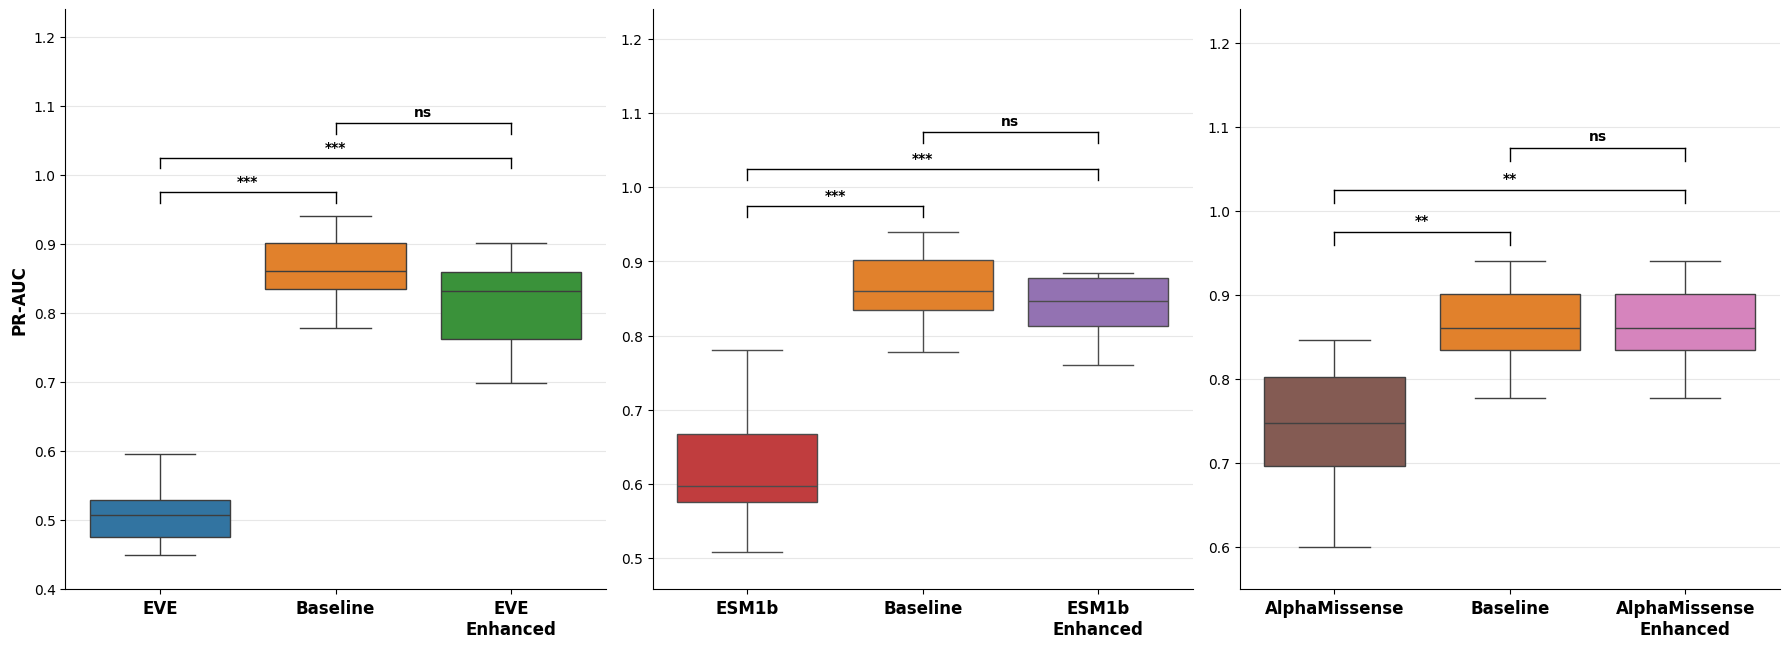


DETAILED PAIRWISE COMPARISON RESULTS BY METHOD GROUP

EVE METHODS

1. EVE vs Baseline
----------------------------------------
Method 1: EVE
  • Sample size: 10
  • Mean PR-AUC: 0.5061
  • Median PR-AUC: 0.5075

Method 2: Baseline
  • Sample size: 10
  • Mean PR-AUC: 0.8634
  • Median PR-AUC: 0.8608

Statistical Test Results:
  • Mann-Whitney U statistic: 0.00
  • p-value: 0.000183
  • Cohen's d (effect size): 7.774
  • Improvement: +70.58%
  • Significance: *** (highly significant)

2. EVE vs EVE Enhanced
----------------------------------------
Method 1: EVE
  • Sample size: 10
  • Mean PR-AUC: 0.5061
  • Median PR-AUC: 0.5075

Method 2: EVE Enhanced
  • Sample size: 10
  • Mean PR-AUC: 0.8132
  • Median PR-AUC: 0.8326

Statistical Test Results:
  • Mann-Whitney U statistic: 0.00
  • p-value: 0.000183
  • Cohen's d (effect size): 5.432
  • Improvement: +60.67%
  • Significance: *** (highly significant)

3. Baseline vs EVE Enhanced
----------------------------------------
Method 1: B

In [110]:

warnings.filterwarnings('ignore')

# Your existing data processing code
noemb_results_df['method'] = noemb_results_df['method'].replace({
    'AlphaMissense': 'AlphaMissense',
    'EVE': 'EVE', 
    'ESM1B': 'ESM1b'  
})

# Combine all results
result_all_df = pd.concat([
    noemb_results_df, 
    fold_scores_def_optuna_df, 
    fold_scores_eve_optuna_df, 
    fold_scores_esm_optuna_df, 
    fold_scores_am_optuna_df
], axis=0, ignore_index=True)

# Clean the data
result_all_df = result_all_df.dropna(subset=['pr_auc'])
result_all_df['pr_auc'] = pd.to_numeric(result_all_df['pr_auc'], errors='coerce')
result_all_df = result_all_df.dropna(subset=['pr_auc'])

# Create method labels that match your requirements
method_mapping = {
    'AlphaMissense': 'AlphaMissense',
    'ESM1b': 'ESM1b', 
    'EVE': 'EVE',
    'Average + PS + gIDRc': 'Baseline',
    'AlphaMissense + Average + PS + gIDRc': 'AlphaMissense Enhanced',
    'ESM1B + Average + PS + gIDRc': 'ESM1b Enhanced',  # Note: mapping ESM1B to ESM1b
    'EVE + Average + PS + gIDRc': 'EVE Enhanced'
}

if 'method_clean' not in result_all_df.columns:
    result_all_df['method_clean'] = result_all_df['method'].map(method_mapping).fillna(result_all_df['method'])

# Define the three method groups for faceted plots
method_groups = [
    {
        'title': 'EVE Methods',
        'methods': ['EVE', 'Baseline', 'EVE Enhanced'],
        'colors': ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    },
    {
        'title': 'ESM1b Methods', 
        'methods': ['ESM1b', 'Baseline', 'ESM1b Enhanced'],
        'colors': ['#d62728', '#ff7f0e', '#9467bd']  # Red, Orange, Purple
    },
    {
        'title': 'AlphaMissense Methods',
        'methods': ['AlphaMissense', 'Baseline', 'AlphaMissense Enhanced'], 
        'colors': ['#8c564b', '#ff7f0e', '#e377c2']  # Brown, Orange, Pink
    }
]

def prepare_group_data(data, method_groups):
    """Prepare data for each method group"""
    group_data = []
    
    for group in method_groups:
        group_df_list = []
        for method in group['methods']:
            method_data = data[data['method_clean'] == method]['pr_auc']
            if len(method_data) > 0:
                temp_df = pd.DataFrame({
                    'pr_auc': method_data,
                    'method': method,
                    'group': group['title']
                })
                group_df_list.append(temp_df)
        
        if group_df_list:
            group_data.append(pd.concat(group_df_list, ignore_index=True))
    
    return pd.concat(group_data, ignore_index=True) if group_data else pd.DataFrame()

def perform_pairwise_tests(data, methods):
    """Perform all pairwise comparisons within a method group"""
    results = []
    
    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1, method2 = methods[i], methods[j]
            
            data1 = data[data['method'] == method1]['pr_auc']
            data2 = data[data['method'] == method2]['pr_auc']
            
            if len(data1) > 0 and len(data2) > 0:
                # Use Mann-Whitney U test (non-parametric)
                statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                
                # Calculate effect size (Cohen's d equivalent for Mann-Whitney)
                mean1, mean2 = data1.mean(), data2.mean()
                pooled_std = np.sqrt(((len(data1)-1)*data1.var() + (len(data2)-1)*data2.var()) / (len(data1)+len(data2)-2))
                cohens_d = (mean2 - mean1) / pooled_std if pooled_std > 0 else 0
                
                results.append({
                    'method1': method1,
                    'method2': method2,
                    'comparison': f'{method1} vs {method2}',
                    'n1': len(data1),
                    'n2': len(data2),
                    'mean1': mean1,
                    'mean2': mean2,
                    'median1': data1.median(),
                    'median2': data2.median(),
                    'p_value': p_value,
                    'statistic': statistic,
                    'cohens_d': cohens_d,
                    'improvement': ((mean2 - mean1) / mean1 * 100) if mean1 > 0 else 0
                })
    
    return pd.DataFrame(results)

def add_significance_annotations(ax, data, methods, stat_results, y_offset=0.02):
    """Add significance brackets for all pairwise comparisons"""
    y_max = data['pr_auc'].max()
    bracket_levels = [y_max + y_offset + i*0.05 for i in range(len(stat_results))]
    
    method_positions = {method: i for i, method in enumerate(methods)}
    
    for idx, (_, row) in enumerate(stat_results.iterrows()):
        x1 = method_positions[row['method1']]
        x2 = method_positions[row['method2']]
        y = bracket_levels[idx]
        
        # Draw bracket
        bracket_height = 0.015
        ax.plot([x1, x1], [y, y + bracket_height], 'k-', linewidth=1)
        ax.plot([x2, x2], [y, y + bracket_height], 'k-', linewidth=1)
        ax.plot([x1, x2], [y + bracket_height, y + bracket_height], 'k-', linewidth=1)
        
        # Format p-value
        p_value = row['p_value']
        if p_value < 0.001:
            p_text = '***'
        elif p_value < 0.01:
            p_text = '**'
        elif p_value < 0.05:
            p_text = '*'
        else:
            p_text = 'ns'
        
        # Add p-value text
        ax.text((x1 + x2) / 2, y + bracket_height + 0.005, p_text, 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

def create_clean_labels(method_order):
    """Create clean, non-overlapping labels for x-axis"""
    clean_labels = []
    
    for method in method_order:
        if method == 'EVE':
            clean_labels.append('EVE')
        elif method == 'ESM1b':
            clean_labels.append('ESM1b')
        elif method == 'AlphaMissense':
            clean_labels.append('AlphaMissense')
        elif method == 'Baseline':
            clean_labels.append('Baseline')
        elif method == 'EVE Enhanced':
            clean_labels.append('EVE\nEnhanced')
        elif method == 'ESM1b Enhanced':
            clean_labels.append('ESM1b\nEnhanced')
        elif method == 'AlphaMissense Enhanced':
            clean_labels.append('AlphaMissense\nEnhanced')
        else:
            clean_labels.append(method)
    
    return clean_labels

# Prepare data for group plots
plot_data = prepare_group_data(result_all_df, method_groups)

# Create the faceted plot with more space for labels
fig, axes = plt.subplots(1, 3, figsize=(18, 7))  # Increased height slightly

# Store all statistical results
all_stat_results = {}

# Create each group plot
for i, group in enumerate(method_groups):
    ax = axes[i]
    
    # Filter data for this group
    group_data = plot_data[plot_data['group'] == group['title']]
    
    if len(group_data) > 0:
        # Perform statistical tests for this group
        stat_results = perform_pairwise_tests(group_data, group['methods'])
        all_stat_results[group['title']] = stat_results
        
        # Create boxplot with custom colors
        available_methods = group_data['method'].unique()
        method_order = [m for m in group['methods'] if m in available_methods]
        colors_subset = [group['colors'][group['methods'].index(m)] for m in method_order]
        
        box_plot = sns.boxplot(data=group_data, x='method', y='pr_auc', 
                              order=method_order, palette=colors_subset, ax=ax)
        
        # Add significance annotations
        if len(stat_results) > 0:
            add_significance_annotations(ax, group_data, method_order, stat_results)
        
        # Customize individual subplot
        #ax.set_title(group['title'], fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('')
        ax.set_ylabel('PR-AUC' if i == 0 else '', fontsize=12, fontweight='bold')
        
        # Create clean labels to prevent overlap
        clean_labels = create_clean_labels(method_order)
        ax.set_xticklabels(clean_labels, fontsize=12, fontweight='bold', ha='center')
        
        # Add grid
        ax.grid(True, alpha=0.3, axis='y')
        
        # Set y-axis limits to accommodate significance brackets
        y_min = group_data['pr_auc'].min() - 0.05
        y_max = group_data['pr_auc'].max() + 0.15 + (len(stat_results) * 0.05)
        ax.set_ylim(y_min, y_max)

# Overall figure formatting - add more space at bottom for labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Add space at bottom for multi-line labels
sns.despine()

# Save the figure
plt.savefig('method_group_comparison_fixed_labels.png', dpi=300, bbox_inches='tight')
plt.savefig('method_group_comparison_fixed_labels.pdf', bbox_inches='tight')

plt.show()

# Print detailed statistical results for each group
print("\n" + "="*100)
print("DETAILED PAIRWISE COMPARISON RESULTS BY METHOD GROUP")
print("="*100)

for group_name, stat_results in all_stat_results.items():
    print(f"\n{group_name.upper()}")
    print("="*60)
    
    for i, row in enumerate(stat_results.itertuples(), 1):
        print(f"\n{i}. {row.comparison}")
        print("-" * 40)
        print(f"Method 1: {row.method1}")
        print(f"  • Sample size: {row.n1}")
        print(f"  • Mean PR-AUC: {row.mean1:.4f}")
        print(f"  • Median PR-AUC: {row.median1:.4f}")
        
        print(f"\nMethod 2: {row.method2}")
        print(f"  • Sample size: {row.n2}")
        print(f"  • Mean PR-AUC: {row.mean2:.4f}")
        print(f"  • Median PR-AUC: {row.median2:.4f}")
        
        print(f"\nStatistical Test Results:")
        print(f"  • Mann-Whitney U statistic: {row.statistic:.2f}")
        print(f"  • p-value: {row.p_value:.6f}")
        print(f"  • Cohen's d (effect size): {row.cohens_d:.3f}")
        print(f"  • Improvement: {row.improvement:+.2f}%")
        
        significance = ""
        if row.p_value < 0.001:
            significance = "*** (highly significant)"
        elif row.p_value < 0.01:
            significance = "** (very significant)"
        elif row.p_value < 0.05:
            significance = "* (significant)"
        else:
            significance = "(not significant)"
        
        print(f"  • Significance: {significance}")

# Create comprehensive summary table
print("\n" + "="*100)
print("COMPREHENSIVE SUMMARY TABLE")
print("="*100)

all_comparisons = []
for group_name, stat_results in all_stat_results.items():
    for _, row in stat_results.iterrows():
        all_comparisons.append({
            'Group': group_name,
            'Method 1': row['method1'],
            'Method 2': row['method2'],
            'Mean PR-AUC 1': row['mean1'],
            'Mean PR-AUC 2': row['mean2'],
            'Improvement (%)': row['improvement'],
            'p-value': row['p_value']
        })

summary_df = pd.DataFrame(all_comparisons)
summary_df = summary_df.round({'Mean PR-AUC 1': 4, 'Mean PR-AUC 2': 4, 'Improvement (%)': 2, 'p-value': 6})
print(summary_df.to_string(index=False))

In [111]:
average_X.to_csv('average_train_data.csv', index=False)

PR-AUC ANALYSIS WITH CONFIDENCE INTERVALS
Calculating PR-AUC with confidence intervals...
Performing statistical comparisons...
Creating visualizations...


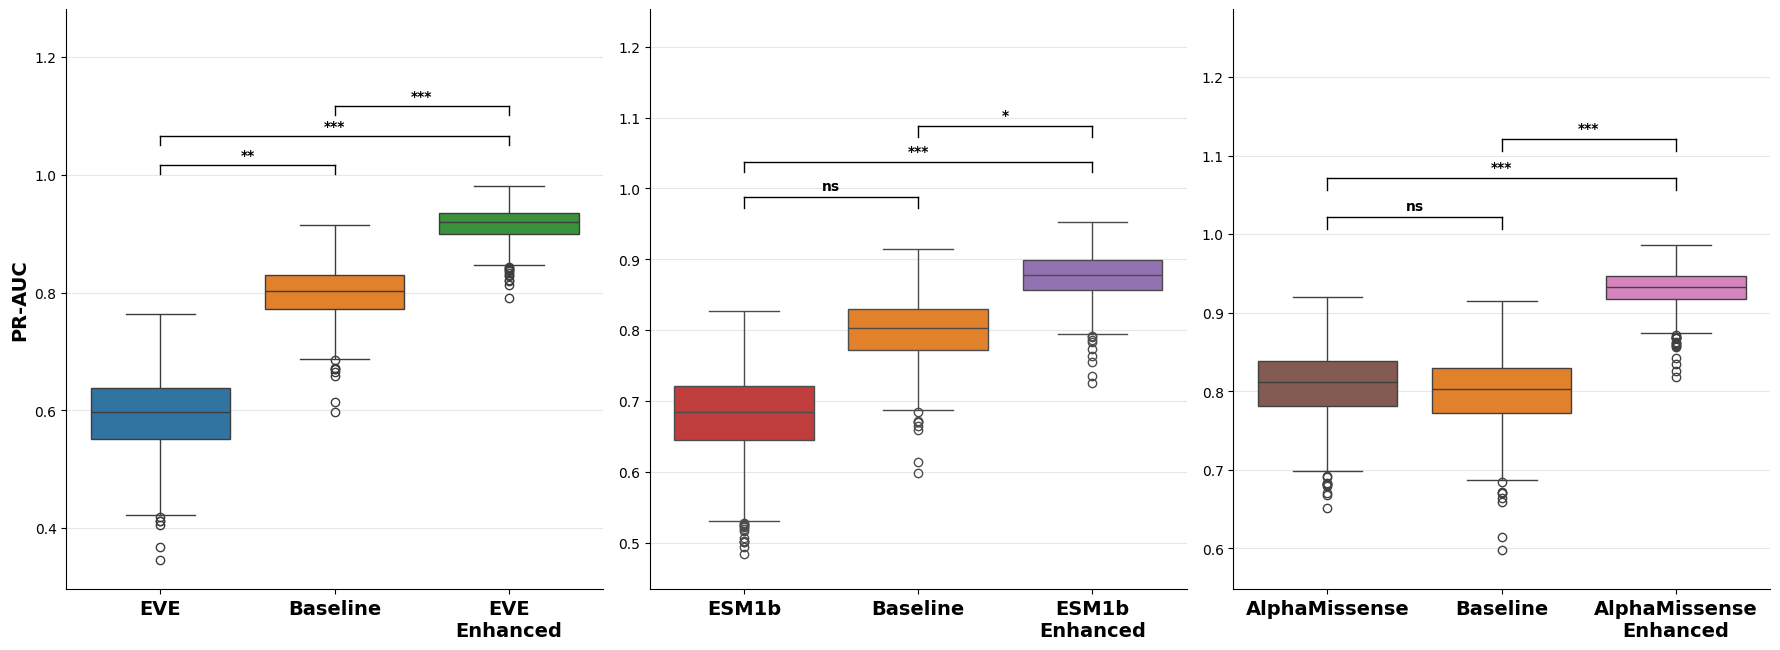


DETAILED PERFORMANCE RESULTS

EVE_rankscore:
  • Sample size: 421
  • Positive samples: 63
  • PR-AUC: 0.5911
  • 95% CI: [0.4711, 0.7058]

ESM1b_rankscore:
  • Sample size: 421
  • Positive samples: 63
  • PR-AUC: 0.6794
  • 95% CI: [0.5638, 0.7803]

AlphaMissense_rankscore:
  • Sample size: 421
  • Positive samples: 63
  • PR-AUC: 0.8078
  • 95% CI: [0.7158, 0.8853]

model_pred:
  • Sample size: 421
  • Positive samples: 63
  • PR-AUC: 0.8000
  • 95% CI: [0.7113, 0.8769]

EVE_enhanced:
  • Sample size: 421
  • Positive samples: 63
  • PR-AUC: 0.9185
  • 95% CI: [0.8608, 0.9620]

ESM1b_enhanced:
  • Sample size: 421
  • Positive samples: 63
  • PR-AUC: 0.8772
  • 95% CI: [0.8096, 0.9298]

AlphaMissense_enhanced:
  • Sample size: 421
  • Positive samples: 63
  • PR-AUC: 0.9310
  • 95% CI: [0.8814, 0.9710]

PAIRWISE COMPARISON RESULTS

EVE METHODS:
------------------------------------------------------------

EVE_rankscore vs model_pred:
  • PR-AUC difference: +0.2089
  • Improvement: 

In [120]:

def bootstrap_prauc_ci(y_true, y_pred, n_bootstrap=1000, random_state=42):
    """
    Calculate PR-AUC with confidence intervals using bootstrap sampling
    """
    np.random.seed(random_state)
    
    # Calculate original PR-AUC
    original_prauc = average_precision_score(y_true, y_pred)
    
    # Bootstrap sampling
    bootstrap_aucs = []
    n_samples = len(y_true)
    
    for i in range(n_bootstrap):
        # Sample with replacement
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        
        # Skip if no positive samples in bootstrap
        if y_true_boot.sum() == 0:
            continue
            
        try:
            boot_prauc = average_precision_score(y_true_boot, y_pred_boot)
            bootstrap_aucs.append(boot_prauc)
        except:
            continue
    
    bootstrap_aucs = np.array(bootstrap_aucs)
    
    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_aucs, 2.5)
    ci_upper = np.percentile(bootstrap_aucs, 97.5)
    
    return {
        'prauc': original_prauc,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'bootstrap_aucs': bootstrap_aucs,
        'std': np.std(bootstrap_aucs)
    }

def bootstrap_imbalanced_metrics(y_true, y_pred, n_bootstrap=200, random_state=42):
    """
    Calculate metrics with confidence intervals accounting for class imbalance.
    Uses multiple approaches to handle imbalance.
    """
    np.random.seed(random_state)
    
    # Store metrics for different approaches
    results = {
        'natural': {'auc': [], 'pr_auc': [], 'balanced_acc': []},
        'balanced': {'auc': [], 'pr_auc': [], 'balanced_acc': []},
        'stratified': {'auc': [], 'pr_auc': [], 'balanced_acc': []}
    }
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Get class information
    unique_classes, class_counts = np.unique(y_true, return_counts=True)
    minority_class = unique_classes[np.argmin(class_counts)]
    majority_class = unique_classes[np.argmax(class_counts)]
    min_class_size = np.min(class_counts)
    
    print(f"Class distribution: {dict(zip(unique_classes, class_counts))}")
    print(f"Minority class: {minority_class}, Majority class: {majority_class}")
    
    for i in range(n_bootstrap):
        natural_indices = np.random.choice(len(y_true), len(y_true), replace=True)
        nat_y_true = y_true[natural_indices]
        nat_y_pred = y_pred[natural_indices]
        
        if len(np.unique(nat_y_true)) > 1:  # Ensure both classes present
            results['natural']['auc'].append(roc_auc_score(nat_y_true, nat_y_pred))
            results['natural']['pr_auc'].append(average_precision_score(nat_y_true, nat_y_pred))
            results['natural']['balanced_acc'].append(balanced_accuracy_score(nat_y_true, nat_y_pred > 0.5))

        pos_indices = np.where(y_true == 1)[0]  
        neg_indices = np.where(y_true == 0)[0]
        
        # Sample equal numbers from each class
        balanced_pos = np.random.choice(pos_indices, min_class_size, replace=True)
        balanced_neg = np.random.choice(neg_indices, min_class_size, replace=True)
        balanced_indices = np.concatenate([balanced_pos, balanced_neg])
        np.random.shuffle(balanced_indices)
        
        bal_y_true = y_true[balanced_indices]
        bal_y_pred = y_pred[balanced_indices]
        
        results['balanced']['auc'].append(roc_auc_score(bal_y_true, bal_y_pred))
        results['balanced']['pr_auc'].append(average_precision_score(bal_y_true, bal_y_pred))
        results['balanced']['balanced_acc'].append(balanced_accuracy_score(bal_y_true, bal_y_pred > 0.5))
        
        strat_indices = []
        for class_val, count in zip(unique_classes, class_counts):
            class_indices = np.where(y_true == class_val)[0]
            # Ensure minimum representation of minority class
            if class_val == minority_class:
                n_samples = max(count, int(0.1 * len(y_true)))  # At least 10% or original count
            else:
                n_samples = count
            
            class_bootstrap = np.random.choice(class_indices, n_samples, replace=True)
            strat_indices.extend(class_bootstrap)
        
        strat_indices = np.array(strat_indices)
        strat_y_true = y_true[strat_indices]
        strat_y_pred = y_pred[strat_indices]
        
        results['stratified']['auc'].append(roc_auc_score(strat_y_true, strat_y_pred))
        results['stratified']['pr_auc'].append(average_precision_score(strat_y_true, strat_y_pred))
        results['stratified']['balanced_acc'].append(balanced_accuracy_score(strat_y_true, strat_y_pred > 0.5))
    
    # Calculate confidence intervals for each approach
    final_results = {}
    for approach in results:
        final_results[approach] = {}
        for metric in results[approach]:
            values = results[approach][metric]
            if len(values) > 0:
                mean_val = np.mean(values)
                ci_lower = np.percentile(values, 2.5)
                ci_upper = np.percentile(values, 97.5)
                std_err = np.std(values)
                
                final_results[approach][metric] = {
                    'mean': mean_val,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'std_error': std_err,
                    'bootstrap_values': values
                }
    
    return final_results

def calculate_method_performance(df, method_columns, label_column='label'):
    """
    Calculate PR-AUC and confidence intervals for multiple methods
    """
    results = []
    
    # Ensure label is binary
    y_true = df[label_column].values
    
    for method in method_columns:
        if method in df.columns:
            y_pred = df[method].values
            
            # Remove NaN values
            mask = ~(np.isnan(y_true) | np.isnan(y_pred))
            y_true_clean = y_true[mask]
            y_pred_clean = y_pred[mask]
            
            if len(y_true_clean) > 0 and y_true_clean.sum() > 0:
                # Calculate PR-AUC with CI
                perf_stats = bootstrap_prauc_ci(y_true_clean, y_pred_clean)
                
                results.append({
                    'method': method,
                    'n_samples': len(y_true_clean),
                    'n_positive': int(y_true_clean.sum()),
                    'prauc': perf_stats['prauc'],
                    'ci_lower': perf_stats['ci_lower'],
                    'ci_upper': perf_stats['ci_upper'],
                    'std': perf_stats['std'],
                    'bootstrap_aucs': perf_stats['bootstrap_aucs']
                })
            else:
                print(f"Warning: No valid data for method {method}")
    
    return pd.DataFrame(results)

def perform_statistical_comparison(results_df, method_groups):
    """
    Perform pairwise statistical comparisons using bootstrap distributions
    """
    comparison_results = []
    
    for group_name, methods in method_groups.items():
        # Get available methods in this group
        available_methods = [m for m in methods if m in results_df['method'].values]
        
        # Perform pairwise comparisons
        for i in range(len(available_methods)):
            for j in range(i+1, len(available_methods)):
                method1, method2 = available_methods[i], available_methods[j]
                
                # Get bootstrap distributions
                boot1 = results_df[results_df['method'] == method1]['bootstrap_aucs'].iloc[0]
                boot2 = results_df[results_df['method'] == method2]['bootstrap_aucs'].iloc[0]
                
                # Calculate difference in bootstrap distributions
                diff_boot = boot2 - boot1
                
                # Calculate p-value (two-tailed test)
                p_value = 2 * min(np.mean(diff_boot <= 0), np.mean(diff_boot >= 0))
                
                # Get original metrics
                prauc1 = results_df[results_df['method'] == method1]['prauc'].iloc[0]
                prauc2 = results_df[results_df['method'] == method2]['prauc'].iloc[0]
                
                # Calculate effect size
                pooled_std = np.sqrt((np.var(boot1) + np.var(boot2)) / 2)
                cohens_d = (prauc2 - prauc1) / pooled_std if pooled_std > 0 else 0
                
                comparison_results.append({
                    'group': group_name,
                    'method1': method1,
                    'method2': method2,
                    'prauc1': prauc1,
                    'prauc2': prauc2,
                    'difference': prauc2 - prauc1,
                    'improvement_pct': ((prauc2 - prauc1) / prauc1 * 100) if prauc1 > 0 else 0,
                    'p_value': p_value,
                    'cohens_d': cohens_d,
                    'ci_diff_lower': np.percentile(diff_boot, 2.5),
                    'ci_diff_upper': np.percentile(diff_boot, 97.5)
                })
    
    return pd.DataFrame(comparison_results)

def create_clean_method_labels(method_order):
    """
    Create clean, non-overlapping labels for x-axis
    """
    clean_labels = []
    
    for method in method_order:
        if method == 'EVE_rankscore':
            clean_labels.append('EVE')
        elif method == 'ESM1b_rankscore':
            clean_labels.append('ESM1b')
        elif method == 'AlphaMissense_rankscore':
            clean_labels.append('AlphaMissense')
        elif method == 'model_pred':
            clean_labels.append('Baseline')
        elif method == 'EVE_enhanced':
            clean_labels.append('EVE\nEnhanced')
        elif method == 'ESM1b_enhanced':
            clean_labels.append('ESM1b\nEnhanced')
        elif method == 'AlphaMissense_enhanced':
            clean_labels.append('AlphaMissense\nEnhanced')
        else:
            # Fallback for any other method names
            if 'rankscore' in method:
                clean_labels.append(method.replace('_rankscore', '').upper())
            elif 'enhanced' in method:
                base_method = method.replace('_enhanced', '')
                clean_labels.append(f'{base_method.upper()}\nEnhanced')
            else:
                clean_labels.append(method.replace('_', ' ').title())
    
    return clean_labels

def plot_prauc_comparison(results_df, method_groups, comparison_results, figsize=(18, 7)):
    """
    Create faceted plots showing PR-AUC as boxplots with significance brackets
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Color mappings
    color_map = {
        'model_pred': '#ff7f0e',  # Orange for baseline
        'EVE_rankscore': '#1f77b4',  # Blue
        'EVE_enhanced': '#2ca02c',   # Green
        'ESM1b_rankscore': '#d62728',  # Red
        'ESM1b_enhanced': '#9467bd',   # Purple
        'AlphaMissense_rankscore': '#8c564b',  # Brown
        'AlphaMissense_enhanced': '#e377c2'    # Pink
    }
    
    for i, (group_name, methods) in enumerate(method_groups.items()):
        ax = axes[i]
        
        # Filter data for this group
        group_data = results_df[results_df['method'].isin(methods)].copy()
        
        if len(group_data) > 0:
            # Reorder methods for consistent display
            method_order = [m for m in methods if m in group_data['method'].values]
            group_data = group_data.set_index('method').loc[method_order].reset_index()
            
            # Create fake data points from bootstrap for boxplot visualization
            plot_data = []
            for _, row in group_data.iterrows():
                bootstrap_aucs = row['bootstrap_aucs']
                method_name = row['method']
                
                # Create a DataFrame for this method's bootstrap samples
                method_df = pd.DataFrame({
                    'pr_auc': bootstrap_aucs,
                    'method': method_name
                })
                plot_data.append(method_df)
            
            if plot_data:
                combined_data = pd.concat(plot_data, ignore_index=True)
                
                # Create custom color palette
                colors = [color_map.get(method, '#333333') for method in method_order]
                
                # Create boxplot
                box_plot = sns.boxplot(data=combined_data, x='method', y='pr_auc', 
                                     order=method_order, palette=colors, ax=ax)
                
                # Get group comparisons for significance brackets
                group_comparisons = comparison_results[comparison_results['group'] == group_name]
                
                # Add significance brackets
                if len(group_comparisons) > 0:
                    add_significance_brackets_boxplot(ax, combined_data, method_order, group_comparisons)
                
                # Customize plot
                ax.set_ylabel('PR-AUC' if i == 0 else '', fontsize=14, fontweight='bold')
                ax.set_xlabel('')
                
                # Create clean labels to prevent overlap
                clean_labels = create_clean_method_labels(method_order)
                ax.set_xticklabels(clean_labels, fontsize=14, fontweight='bold', ha='center')
                
                # Add grid
                ax.grid(True, alpha=0.3, axis='y')
                ax.set_axisbelow(True)
                
                # Set y-axis limits to accommodate significance brackets
                y_min = combined_data['pr_auc'].min() - 0.05
                y_max = combined_data['pr_auc'].max() + 0.15 + (len(group_comparisons) * 0.05)
                ax.set_ylim(y_min, y_max)
    
    # Add space at bottom for multi-line labels
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    sns.despine()
    
    # Save the figure
    plt.savefig('prauc_comparison_boxplot.png', dpi=300, bbox_inches='tight')
    plt.savefig('prauc_comparison_boxplot.pdf', bbox_inches='tight')
    
    plt.show()

def add_significance_brackets_boxplot(ax, data, methods, stat_results, y_offset=0.02):
    """
    Add significance brackets for boxplot comparisons
    """
    y_max = data['pr_auc'].max()
    bracket_levels = [y_max + y_offset + i*0.05 for i in range(len(stat_results))]
    
    method_positions = {method: i for i, method in enumerate(methods)}
    
    for idx, (_, row) in enumerate(stat_results.iterrows()):
        x1 = method_positions[row['method1']]
        x2 = method_positions[row['method2']]
        y = bracket_levels[idx]
        
        # Draw bracket
        bracket_height = 0.015
        ax.plot([x1, x1], [y, y + bracket_height], 'k-', linewidth=1)
        ax.plot([x2, x2], [y, y + bracket_height], 'k-', linewidth=1)
        ax.plot([x1, x2], [y + bracket_height, y + bracket_height], 'k-', linewidth=1)
        
        # Format p-value
        p_value = row['p_value']
        if p_value < 0.001:
            p_text = '***'
        elif p_value < 0.01:
            p_text = '**'
        elif p_value < 0.05:
            p_text = '*'
        else:
            p_text = 'ns'
        
        # Add p-value text
        ax.text((x1 + x2) / 2, y + bracket_height + 0.005, p_text, 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Main analysis function
def analyze_model_performance(df, label_column='label'):
    """
    Main function to analyze model performance with confidence intervals
    
    Parameters:
    df: DataFrame with prediction results
    label_column: name of the column containing true labels
    """
    print("="*80)
    print("PR-AUC ANALYSIS WITH CONFIDENCE INTERVALS")
    print("="*80)
    
    # Define method groups for comparison
    method_groups = {
        'EVE Methods': ['EVE_rankscore', 'model_pred', 'EVE_enhanced'],
        'ESM1b Methods': ['ESM1b_rankscore', 'model_pred', 'ESM1b_enhanced'],
        'AlphaMissense Methods': ['AlphaMissense_rankscore', 'model_pred', 'AlphaMissense_enhanced']
    }
    
    # Define all methods to analyze
    all_methods = ['EVE_rankscore', 'ESM1b_rankscore', 'AlphaMissense_rankscore',
                   'model_pred', 'EVE_enhanced', 'ESM1b_enhanced', 'AlphaMissense_enhanced']
    
    # Calculate performance metrics
    print("Calculating PR-AUC with confidence intervals...")
    results_df = calculate_method_performance(df, all_methods, label_column)
    
    # Perform statistical comparisons
    print("Performing statistical comparisons...")
    comparison_results = perform_statistical_comparison(results_df, method_groups)
    
    # Create visualization
    print("Creating visualizations...")
    plot_prauc_comparison(results_df, method_groups, comparison_results)
    
    # Print detailed results
    print("\n" + "="*80)
    print("DETAILED PERFORMANCE RESULTS")
    print("="*80)
    
    for _, row in results_df.iterrows():
        print(f"\n{row['method']}:")
        print(f"  • Sample size: {row['n_samples']}")
        print(f"  • Positive samples: {row['n_positive']}")
        print(f"  • PR-AUC: {row['prauc']:.4f}")
        print(f"  • 95% CI: [{row['ci_lower']:.4f}, {row['ci_upper']:.4f}]")
    
    # Print comparison results
    print("\n" + "="*80)
    print("PAIRWISE COMPARISON RESULTS")
    print("="*80)
    
    for group_name in method_groups.keys():
        group_comparisons = comparison_results[comparison_results['group'] == group_name]
        
        if len(group_comparisons) > 0:
            print(f"\n{group_name.upper()}:")
            print("-" * 60)
            
            for _, row in group_comparisons.iterrows():
                print(f"\n{row['method1']} vs {row['method2']}:")
                print(f"  • PR-AUC difference: {row['difference']:+.4f}")
                print(f"  • Improvement: {row['improvement_pct']:+.2f}%")
                print(f"  • 95% CI of difference: [{row['ci_diff_lower']:+.4f}, {row['ci_diff_upper']:+.4f}]")
                print(f"  • p-value: {row['p_value']:.6f}")
                print(f"  • Cohen's d: {row['cohens_d']:.3f}")
                
                # Significance interpretation
                if row['p_value'] < 0.001:
                    sig_text = "*** (highly significant)"
                elif row['p_value'] < 0.01:
                    sig_text = "** (very significant)"
                elif row['p_value'] < 0.05:
                    sig_text = "* (significant)"
                else:
                    sig_text = "(not significant)"
                print(f"  • Significance: {sig_text}")
    
    # Create summary table
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    
    summary_table = results_df[['method', 'prauc', 'ci_lower', 'ci_upper', 'n_samples', 'n_positive']].copy()
    summary_table['CI_width'] = summary_table['ci_upper'] - summary_table['ci_lower']
    summary_table = summary_table.round(4)
    print(summary_table.to_string(index=False))
    
    # Save results
    results_save = results_df.drop(['bootstrap_aucs'], axis=1, errors='ignore')
    results_save.to_csv('prauc_results_with_ci.csv', index=False)
    comparison_results.to_csv('pairwise_comparisons_with_ci.csv', index=False)
    
    print(f"\nResults saved to:")
    print(f"  • prauc_results_with_ci.csv")
    print(f"  • pairwise_comparisons_with_ci.csv")
    
    return results_df, comparison_results

# Usage example:
results_df, comparison_results = analyze_model_performance(
    model_test_output_df, 
    label_column='label'
)
    
print("Analysis complete! Check the generated plots and CSV files for detailed results.")